PROJET 7 OPENCLASSROOM : Implémentez un modèle de scoring
    
- Votre mission
- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.




- Compétences évaluées
- Utiliser un logiciel de version de code pour assurer l’intégration du modèle
- Déployer un modèle via une API dans le Web
- Réaliser un dashboard pour présenter son travail de modélisation
- Rédiger une note méthodologique afin de communiquer sa démarche de modélisation
- Présenter son travail de modélisation à l'oral

In [3]:
# Chargement des librairies de travail 
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
#from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import lightgbm as lgb
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report, log_loss, \
roc_curve, auc, precision_recall_curve,confusion_matrix,ConfusionMatrixDisplay
from pickle import dump
import shap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import explainerdashboard
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
%matplotlib inline
shap.initjs()
#https://towardsdatascience.com/using-principal-component-analysis-pca-for-machine-learning-b6e803f5bf1e
#https://www.projectpro.io/recipes/optimize-hyper-parameters-of-logistic-regression-model-using-grid-search-in-python
#https://www.youtube.com/watch?v=u0Syto1oAGA - deployer modele avec streamlit
#https://www.youtube.com/watch?v=u0Syto1oAGA - deployer un modele avec flask
#https://github.com/MeltemYildirim227/Projet_7/blob/main/P7_03_Dashboard/dashboard.py - appli dash
#https://plotly.com/python/waterfall-charts/
#https://github.com/vkous/Projet7-Openclassrooms/blob/master/dashboard.py - appel de l'api
#https://github.com/JulienDiGiulio/openclassrooms_projet7

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


# Analyse des données

## Chargement des données

In [17]:
# Chargement des différents datasets
list_data = ["sample_submission", "application_test", "application_train", "bureau_balance", "bureau",
             "previous_application", "credit_card_balance", "POS_CASH_balance", "installments_payments"]

for i in list_data:
    print(i+".csv")
    globals()[i] = pd.read_csv(i+".csv",sep= ',')

sample_submission.csv
application_test.csv
application_train.csv
bureau_balance.csv
bureau.csv
previous_application.csv
credit_card_balance.csv
POS_CASH_balance.csv
installments_payments.csv


In [3]:
#Nombre de lignes et colonnes par table de données
for i in list_data:
    print("pour", i, ":" , globals()[i].shape)

pour sample_submission : (48744, 2)
pour application_test : (48744, 121)
pour application_train : (307511, 122)
pour bureau_balance : (27299925, 3)
pour bureau : (1716428, 17)
pour previous_application : (1670214, 37)
pour credit_card_balance : (3840312, 23)
pour POS_CASH_balance : (10001358, 8)
pour installments_payments : (13605401, 8)


In [6]:
# je regarde toutes les colonnes de la table principale
#  SK_ID_CURR - TARGET - NAME_CONTRAT_TYPE - CODE_GENDER - NAME_INCOME_TYPE - NAME_EDUCATION_TYPE - NAME_FAMILY_STATUS
# OCCUPATION_TYPE - ORGANIZATION_TYPE - NAME_HOUSING_TYPE - AMT_INCOME_TOTAL - AMT_CREDIT - AMT_ANNUITY - AMT_GOODS_PRICE
# CNT_CHILDREN - FLAG_OWN_CAR
pd.set_option('display.max_columns', application_train .shape[1])
application_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [7]:
pd.set_option('display.max_columns', sample_submission.shape[1])
sample_submission.head()

SK_ID_CURR  TARGET
0      100001     0.5
1      100005     0.5
2      100013     0.5
3      100028     0.5
4      100038     0.5

In [8]:
pd.set_option('display.max_columns', bureau_balance.shape[1])
bureau_balance .head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [9]:
pd.set_option('display.max_columns', bureau.shape[1])
bureau.head()

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0      215354       5714462        Closed      currency 1         -497   
1      215354       5714463        Active      currency 1         -208   
2      215354       5714464        Active      currency 1         -203   
3      215354       5714465        Active      currency 1         -203   
4      215354       5714466        Active      currency 1         -629   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0               -153.0             -153.0   
1                   0               1075.0                NaN   
2                   0                528.0                NaN   
3                   0                  NaN                NaN   
4                   0               1197.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                     NaN                   0         91323.0   
1                     NaN                   0        225000.0   
2                     NaN                   0        464323.5   
3                     NaN                   0         90000.0   
4                 77674.5                   0       2700000.0   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                  0.0                   NaN                     0.0   
1             171342.0                   NaN                     0.0   
2                  NaN                   NaN                     0.0   
3                  NaN                   NaN                     0.0   
4                  NaN                   NaN                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                -131          NaN  
1      Credit card                 -20          NaN  
2  Consumer credit                 -16          NaN  
3      Credit card                 -16          NaN  
4  Consumer credit                 -21          NaN

In [10]:
pd.set_option('display.max_columns', previous_application.shape[1])
previous_application.head()

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  \
0     2030495      271877     Consumer loans     1730.430          17145.0   
1     2802425      108129         Cash loans    25188.615         607500.0   
2     2523466      122040         Cash loans    15060.735         112500.0   
3     2819243      176158         Cash loans    47041.335         450000.0   
4     1784265      202054         Cash loans    31924.395         337500.0   

   AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  \
0     17145.0               0.0          17145.0                   SATURDAY   
1    679671.0               NaN         607500.0                   THURSDAY   
2    136444.5               NaN         112500.0                    TUESDAY   
3    470790.0               NaN         450000.0                     MONDAY   
4    404055.0               NaN         337500.0                   THURSDAY   

   HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  \
0                       15                           Y   
1                       11                           Y   
2                       11                           Y   
3                        7                           Y   
4                        9                           Y   

   NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  \
0                       1                0.0               0.182832   
1                       1                NaN                    NaN   
2                       1                NaN                    NaN   
3                       1                NaN                    NaN   
4                       1                NaN                    NaN   

   RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  \
0                  0.867336                    XAP             Approved   
1                       NaN                    XNA             Approved   
2                       NaN                    XNA             Approved   
3                       NaN                    XNA             Approved   
4                       NaN                Repairs              Refused   

   DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE  \
0            -73  Cash through the bank                XAP              NaN   
1           -164                    XNA                XAP    Unaccompanied   
2           -301  Cash through the bank                XAP  Spouse, partner   
3           -512  Cash through the bank                XAP              NaN   
4           -781  Cash through the bank                 HC              NaN   

  NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
0         Repeater              Mobile            POS               XNA   
1         Repeater                 XNA           Cash            x-sell   
2         Repeater                 XNA           Cash            x-sell   
3         Repeater                 XNA           Cash            x-sell   
4         Repeater                 XNA           Cash           walk-in   

              CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  \
0             Country-wide                35         Connectivity   
1           Contact center                -1                  XNA   
2  Credit and cash offices                -1                  XNA   
3  Credit and cash offices                -1                  XNA   
4  Credit and cash offices                -1                  XNA   

   CNT_PAYMENT NAME_YIELD_GROUP       PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  \
0         12.0           middle  POS mobile with interest            365243.0   
1         36.0       low_action          Cash X-Sell: low            365243.0   
2         12.0             high         Cash X-Sell: high            365243.0   
3         12.0           middle       Cash X-Sell: middle            365243.0   
4         24.0             high         Cash Street: high                 NaN   

   D

In [11]:
pd.set_option('display.max_columns', credit_card_balance.shape[1])
credit_card_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0     2562384      378907              -6       56.970   
1     2582071      363914              -1    63975.555   
2     1740877      371185              -7    31815.225   
3     1389973      337855              -4   236572.110   
4     1891521      126868              -1   453919.455   

   AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
0                   135000                       0.0                 877.5   
1                    45000                    2250.0                2250.0   
2                   450000                       0.0                   0.0   
3                   225000                    2250.0                2250.0   
4                   450000                       0.0               11547.0   

   AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
0                         0.0                     877.5   
1                         0.0                       0.0   
2                         0.0                       0.0   
3                         0.0                       0.0   
4                         0.0                   11547.0   

   AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  \
0                 1700.325               1800.0                     1800.0   
1                 2250.000               2250.0                     2250.0   
2                 2250.000               2250.0                     2250.0   
3                11795.760              11925.0                    11925.0   
4                22924.890              27000.0                    27000.0   

   AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  \
0                     0.000          0.000                 0.000   
1                 60175.080      64875.555             64875.555   
2                 26926.425      31460.085             31460.085   
3                224949.285     233048.970            233048.970   
4                443044.395     453919.455            453919.455   

   CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0                       0.0                     1                         0.0   
1                       1.0                     1                         0.0   
2                       0.0                     0                         0.0   
3                       1.0                     1                         0.0   
4                       0.0                     1                         0.0   

   CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  \
0                       1.0                       35.0               Active   
1                       0.0                       69.0               Active   
2                       0.0                       30.0               Active   
3                       0.0                       10.0               Active   
4                       1.0                      101.0               Active   

   SK_DPD  SK_DPD_DEF  
0       0           0  
1       0           0  
2       0           0  
3       0           0  
4       0           0

In [12]:
pd.set_option('display.max_columns', POS_CASH_balance.shape[1])
POS_CASH_balance.head()

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   
1     1715348      367990             -33            36.0   
2     1784872      397406             -32            12.0   
3     1903291      269225             -35            48.0   
4     2341044      334279             -35            36.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
1                   35.0               Active       0           0  
2                    9.0               Active       0           0  
3                   42.0               Active       0           0  
4                   35.0               Active       0           0

In [13]:
pd.set_option('display.max_columns', installments_payments.shape[1])
installments_payments.head()

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  \
0     1054186      161674                     1.0                      6   
1     1330831      151639                     0.0                     34   
2     2085231      193053                     2.0                      1   
3     2452527      199697                     1.0                      3   
4     2714724      167756                     1.0                      2   

   DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT  
0          -1180.0             -1187.0        6948.360     6948.360  
1          -2156.0             -2156.0        1716.525     1716.525  
2            -63.0               -63.0       25425.000    25425.000  
3          -2418.0             -2426.0       24350.130    24350.130  
4          -1383.0             -1366.0        2165.040     2160.585

## Analyse de la table principale - application_train


In [16]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [14]:
# Analyse des champs numeriques - 106 colonnes 
application_train.select_dtypes(exclude="object")

SK_ID_CURR  TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  ...  \
0           100002       1             0          202500.0  ...   
1           100003       0             0          270000.0  ...   
2           100004       0             0           67500.0  ...   
3           100006       0             0          135000.0  ...   
4           100007       0             0          121500.0  ...   
...            ...     ...           ...               ...  ...   
307506      456251       0             0          157500.0  ...   
307507      456252       0             0           72000.0  ...   
307508      456253       0             0          153000.0  ...   
307509      456254       1             0          171000.0  ...   
307510      456255       0             0          157500.0  ...   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                              0.0                        0.0   
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              0.0                        0.0   
...                            ...                        ...   
307506                         NaN                        NaN   
307507                         NaN                        NaN   
307508                         0.0                        1.0   
307509                         0.0                        0.0   
307510                         0.0                        2.0   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                             0.0                         1.0  
1                             0.0                         0.0  
2                             0.0                         0.0  
3                             NaN                         NaN  
4                             0.0                         0.0  
...                           ...                         ...  
307506                        NaN                         NaN  
307507                        NaN                         NaN  
307508                        0.0                         1.0  
307509                        0.0                         0.0  
307510                        0.0                         1.0  

[307511 rows x 106 columns]

In [26]:
# Stats descriptives globales
# de nombreuses variables, apres analyses des descriptions des différents champs, je vais selectionner les plus pertinentes
application_train[['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']].describe()

AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE
count      3.075110e+05  3.075110e+05  307499.000000     3.072330e+05
mean       1.687979e+05  5.990260e+05   27108.573909     5.383962e+05
std        2.371231e+05  4.024908e+05   14493.737315     3.694465e+05
min        2.565000e+04  4.500000e+04    1615.500000     4.050000e+04
25%        1.125000e+05  2.700000e+05   16524.000000     2.385000e+05
50%        1.471500e+05  5.135310e+05   24903.000000     4.500000e+05
75%        2.025000e+05  8.086500e+05   34596.000000     6.795000e+05
max        1.170000e+08  4.050000e+06  258025.500000     4.050000e+06

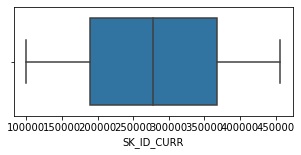

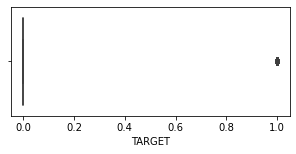

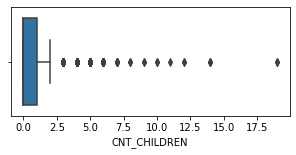

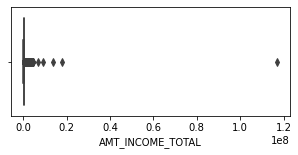

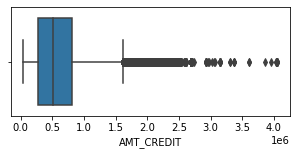

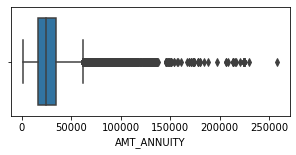

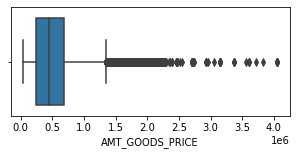

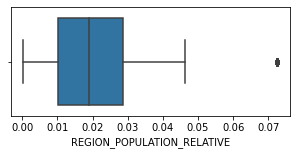

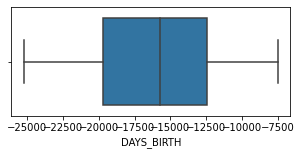

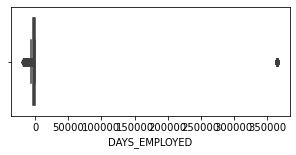

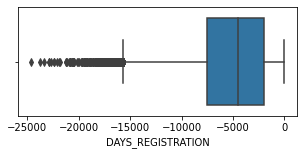

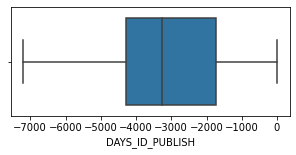

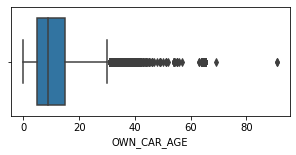

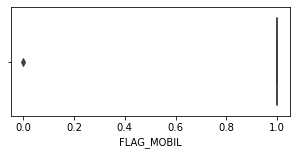

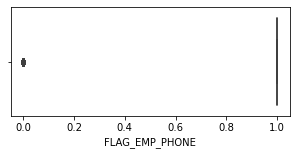

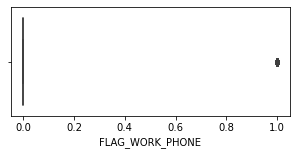

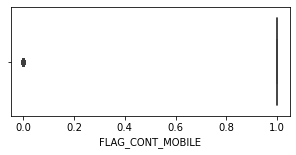

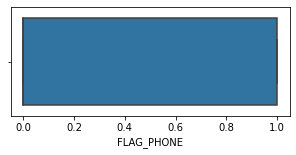

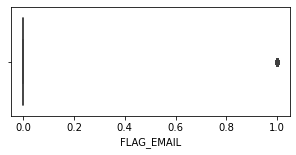

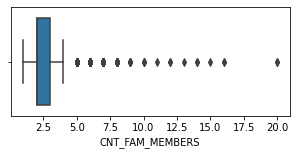

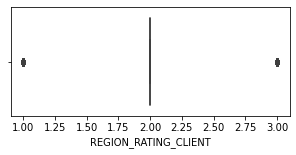

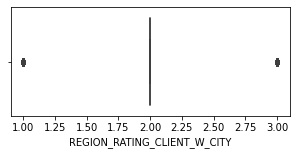

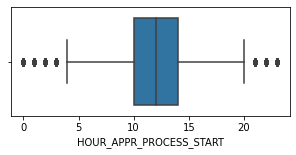

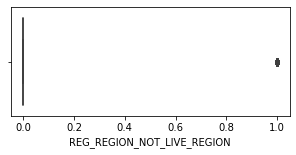

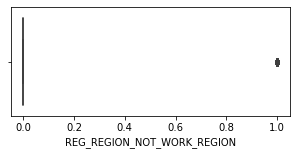

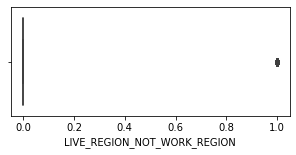

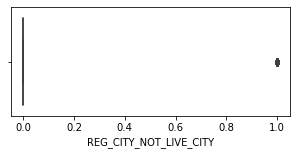

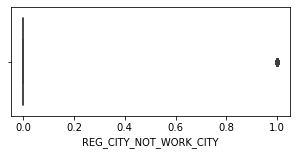

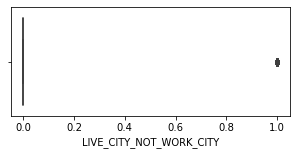

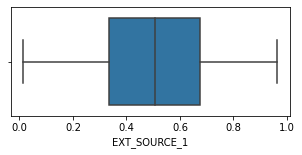

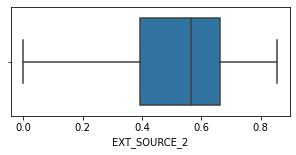

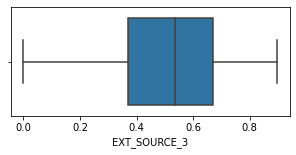

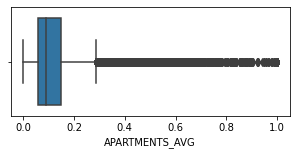

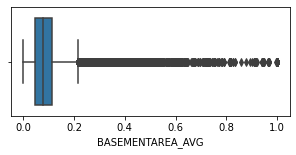

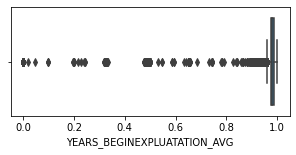

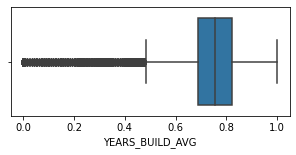

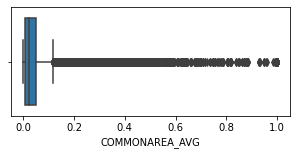

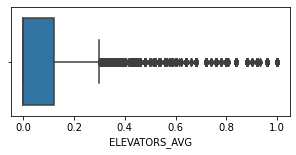

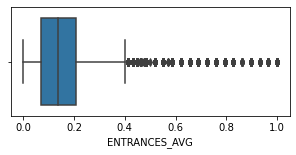

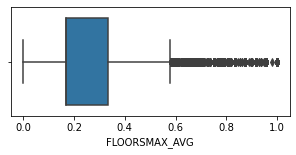

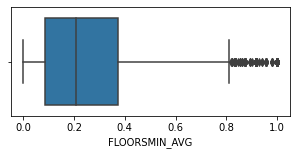

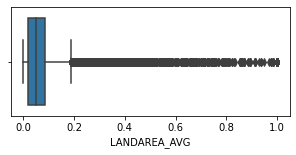

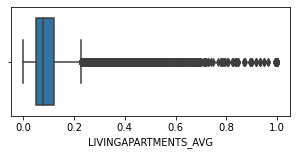

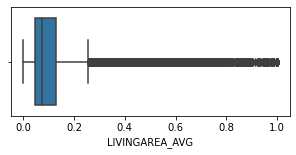

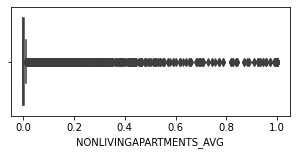

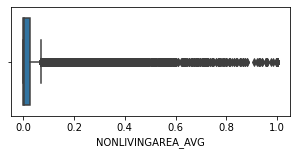

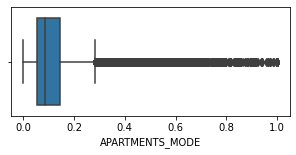

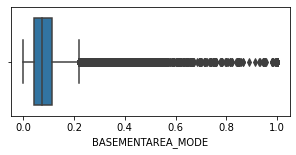

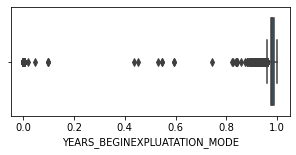

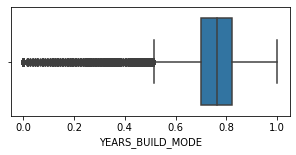

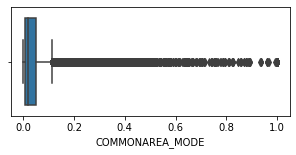

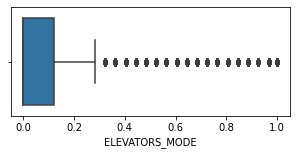

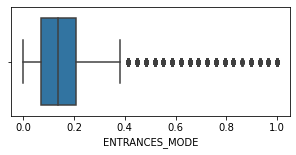

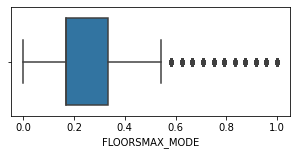

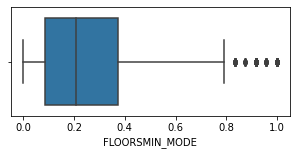

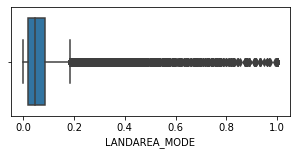

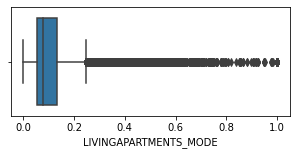

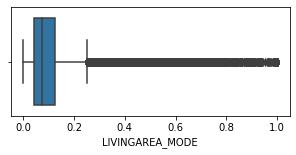

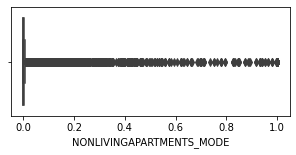

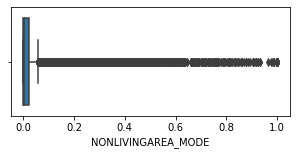

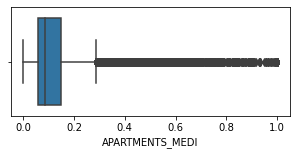

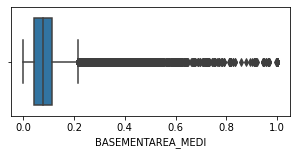

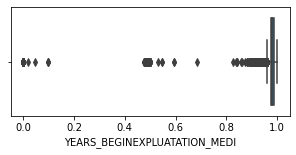

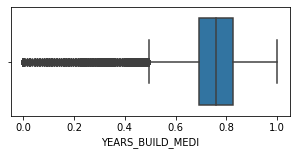

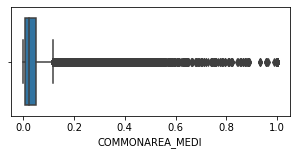

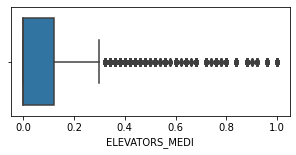

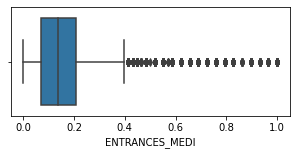

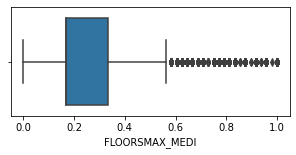

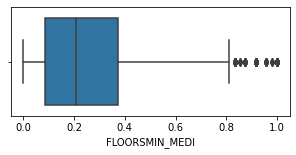

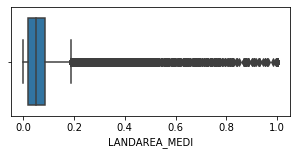

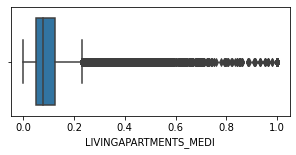

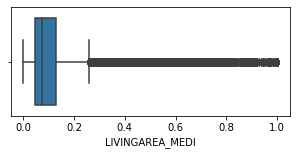

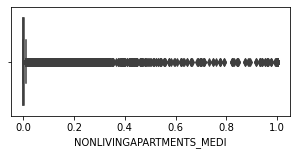

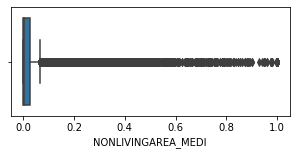

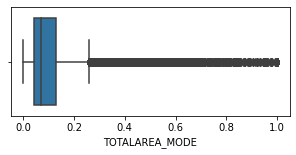

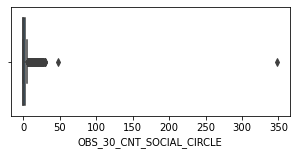

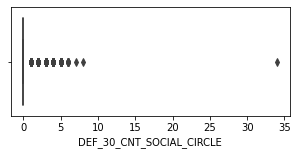

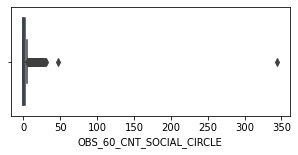

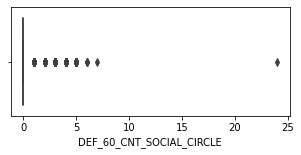

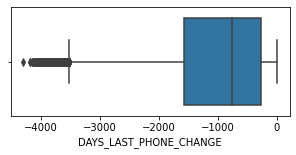

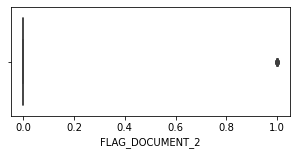

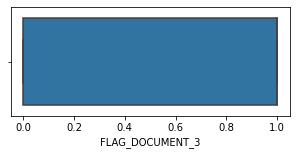

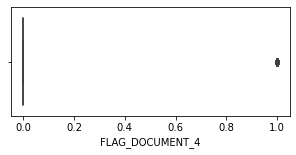

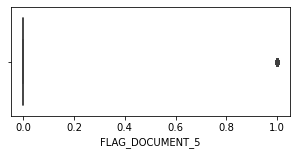

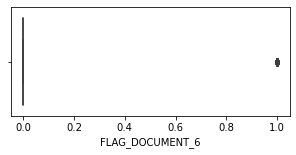

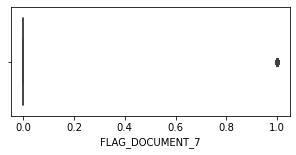

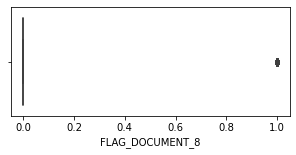

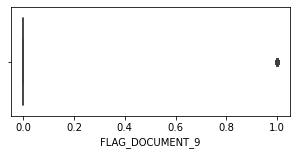

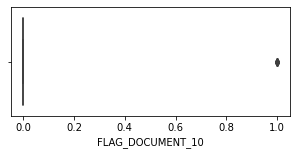

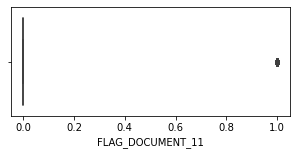

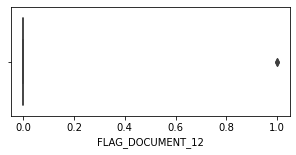

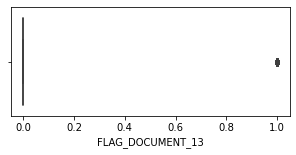

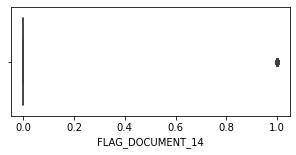

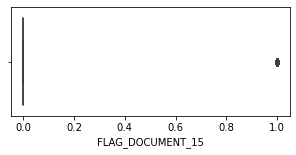

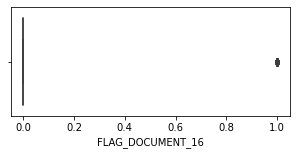

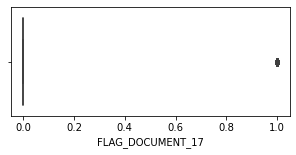

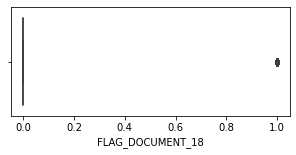

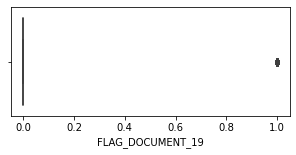

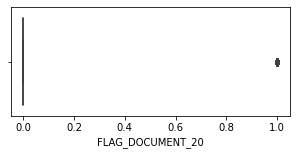

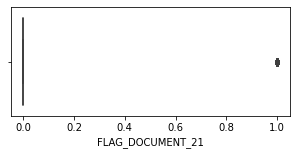

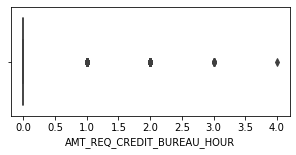

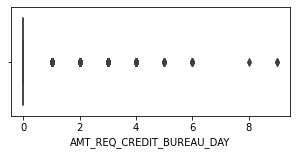

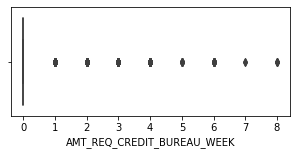

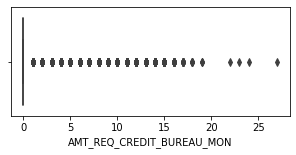

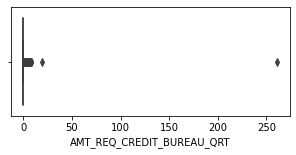

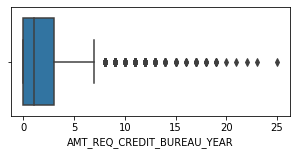

In [19]:
# Analyse des boxplots de mes données
for col in application_train.select_dtypes(exclude="object"):
    plt.figure(figsize=(5, 2))
    sns.boxplot(x=application_train[col])
    plt.show()

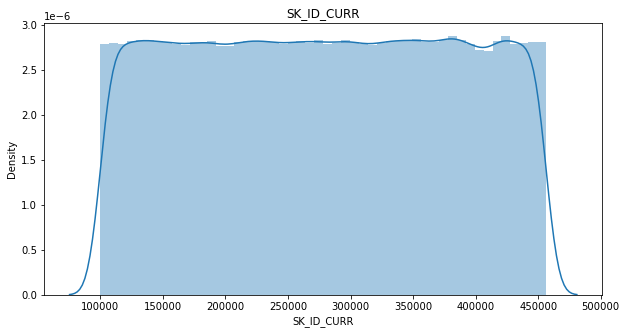

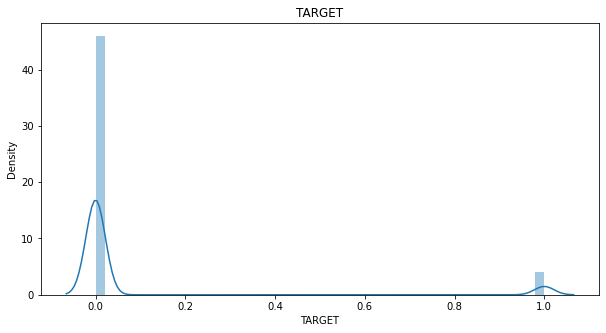

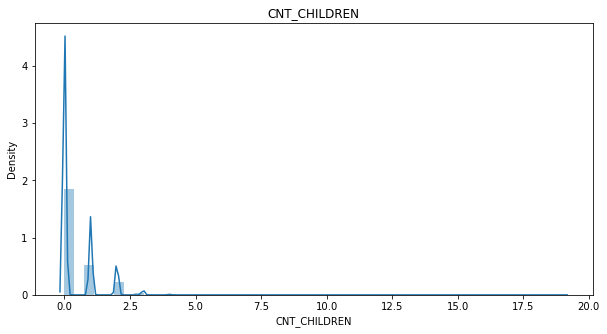

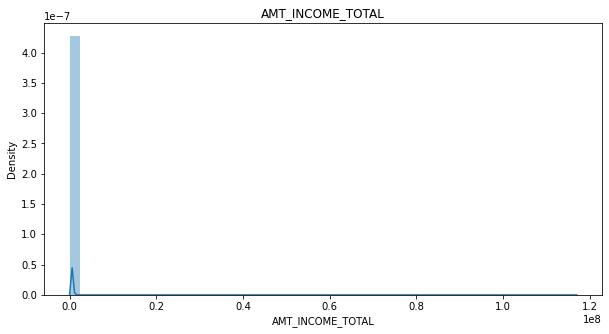

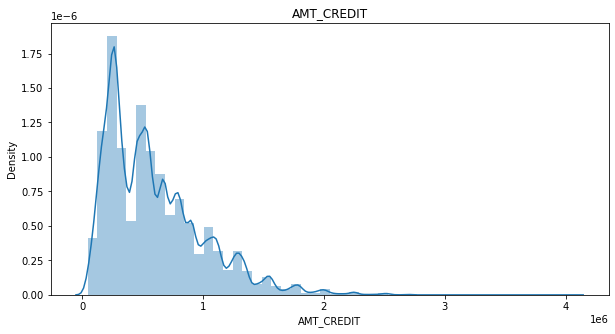

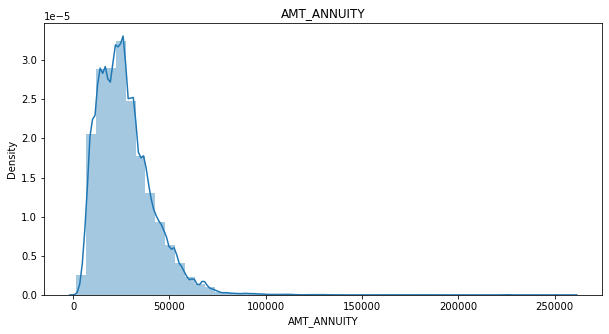

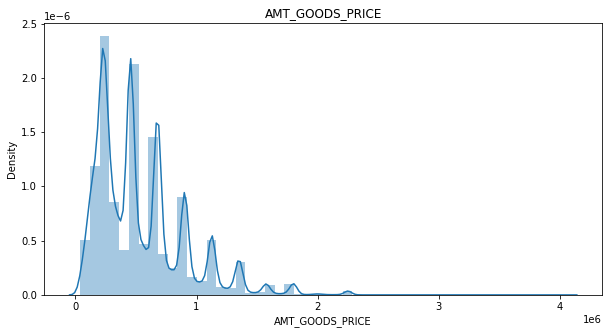

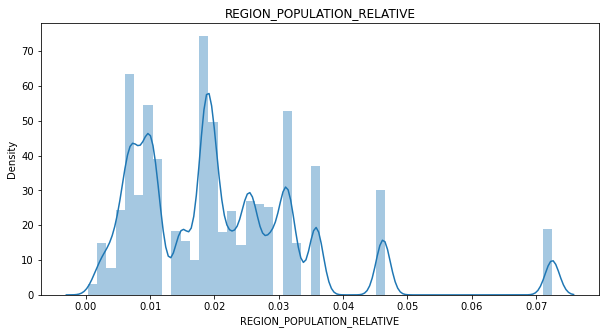

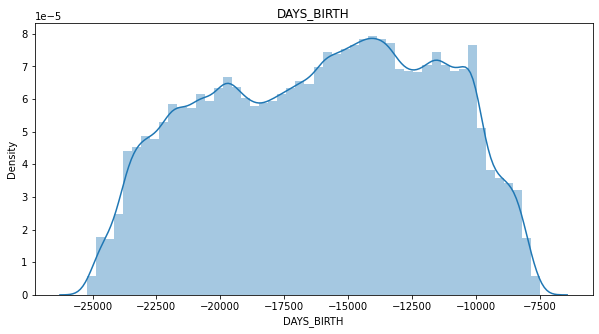

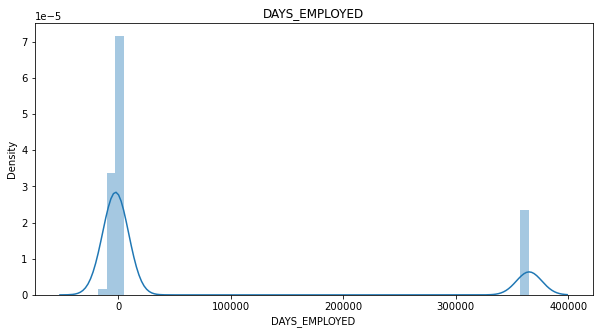

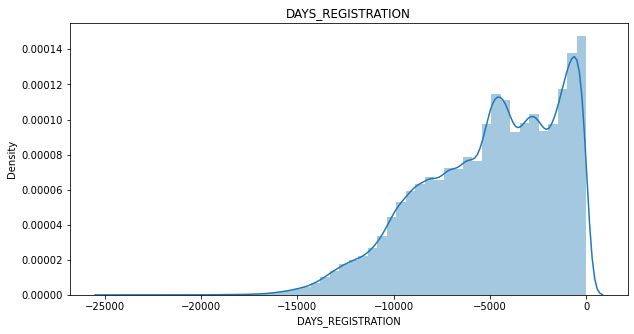

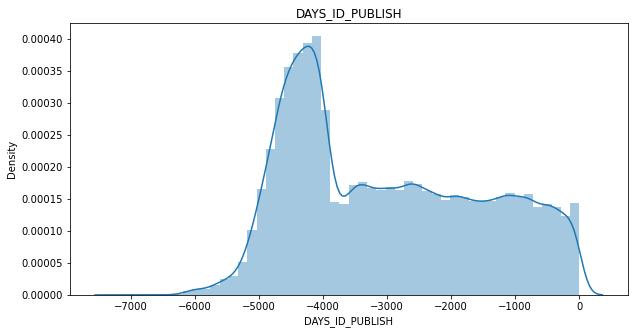

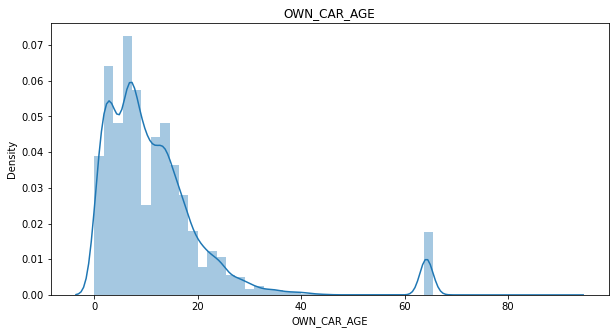

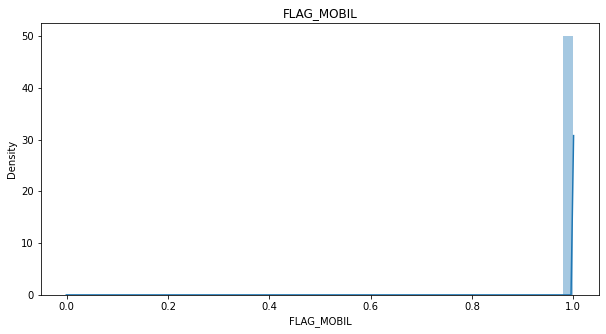

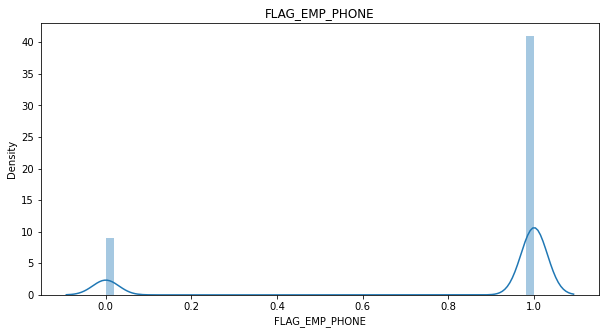

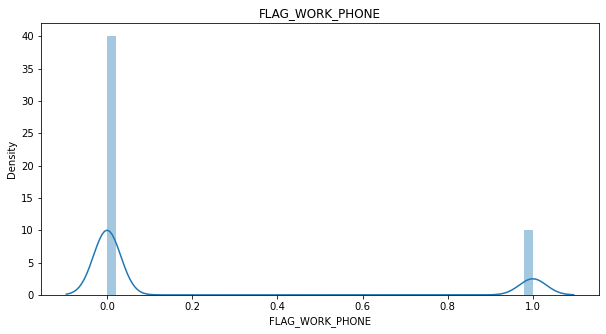

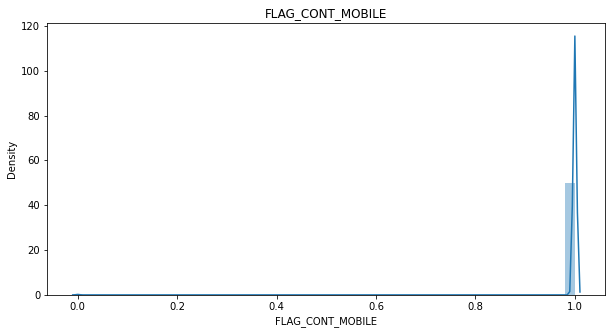

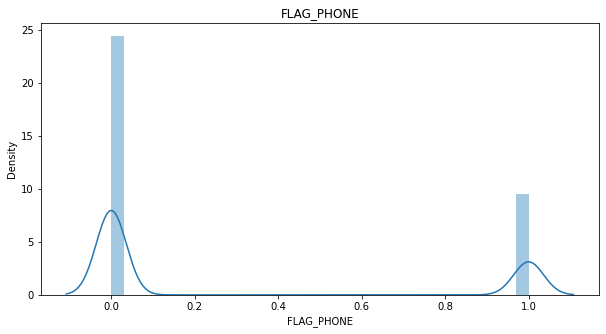

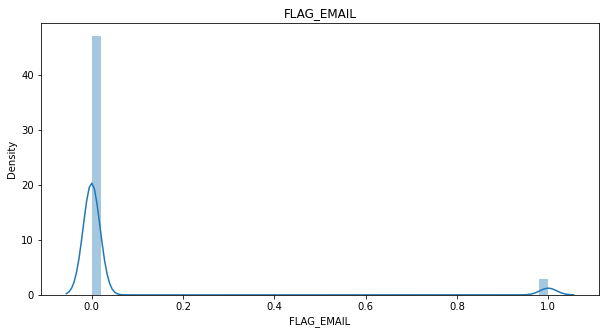

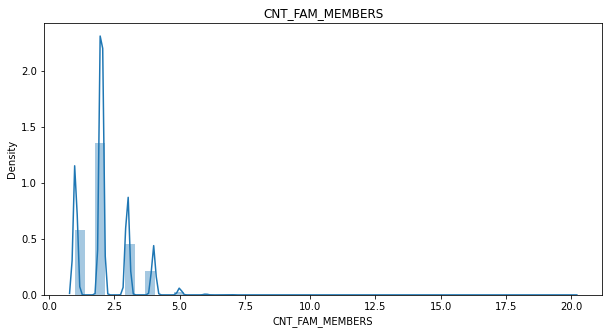

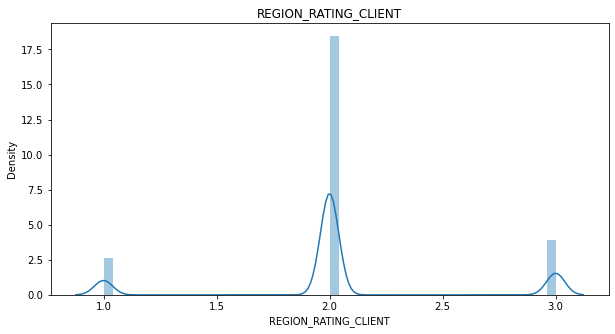

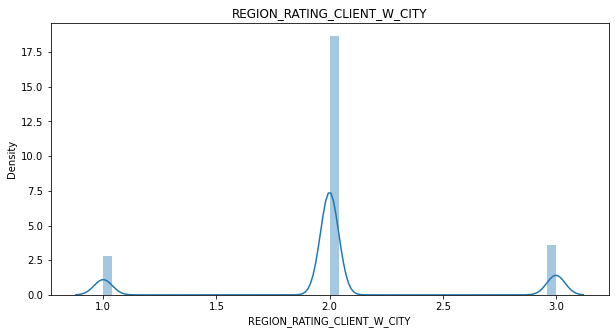

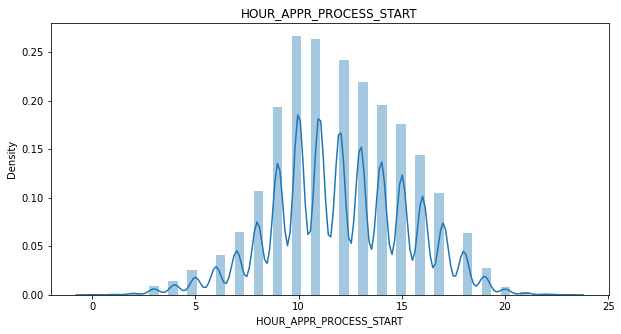

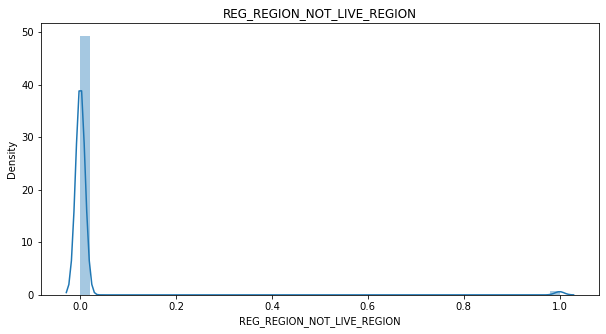

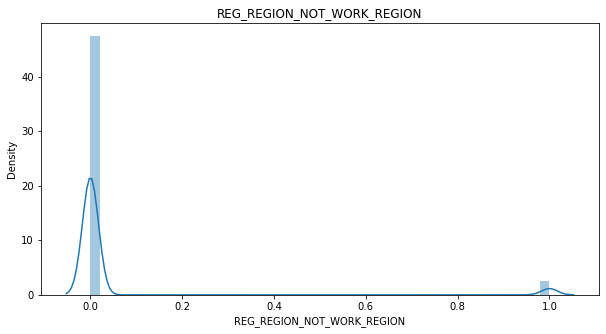

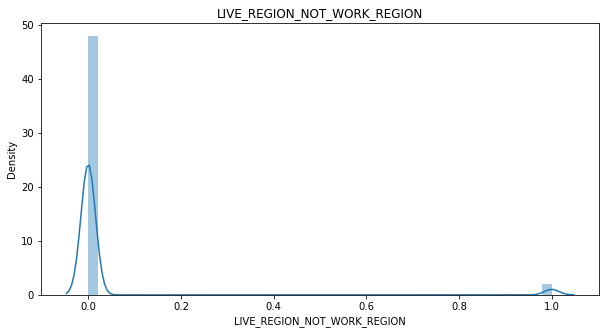

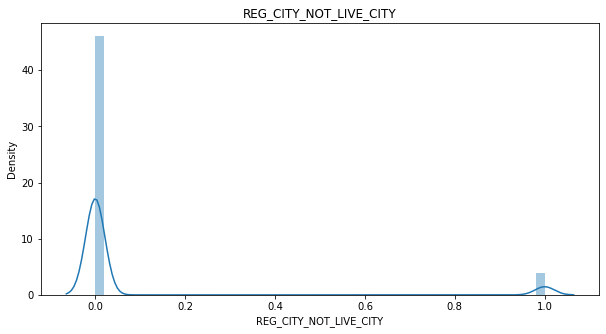

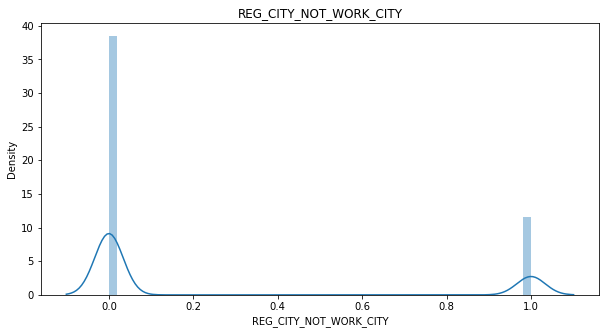

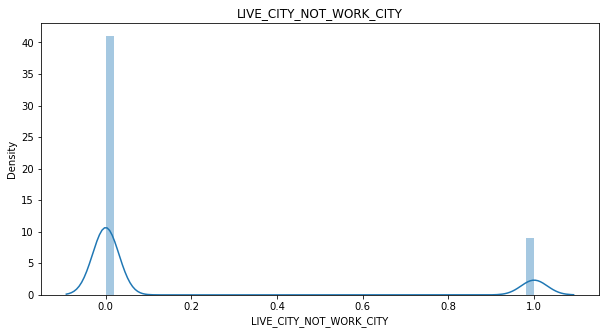

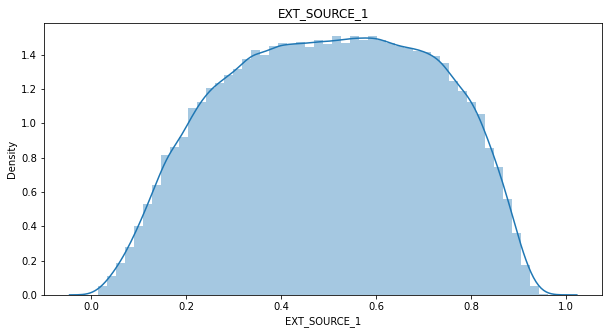

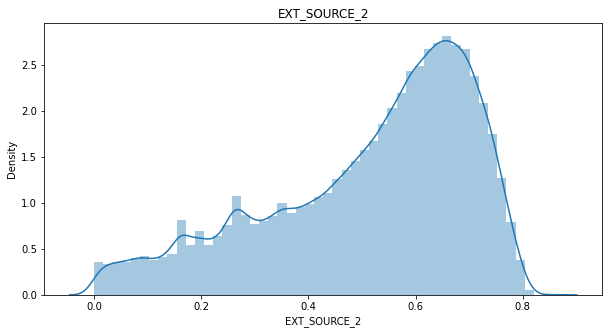

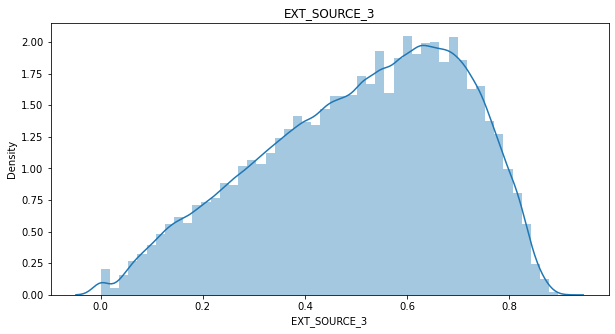

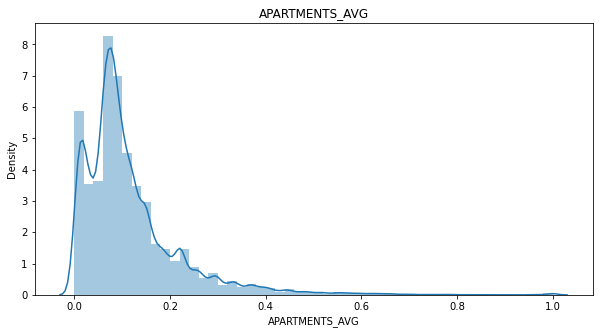

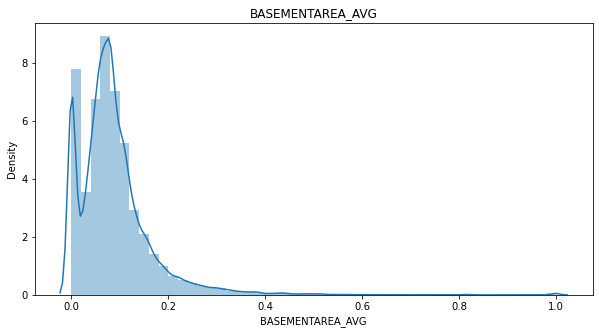

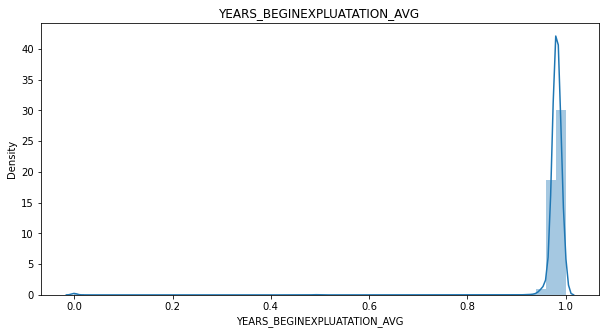

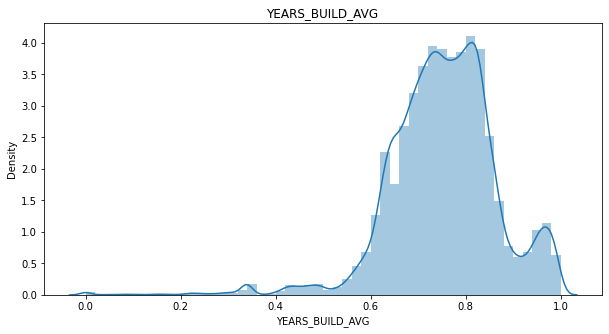

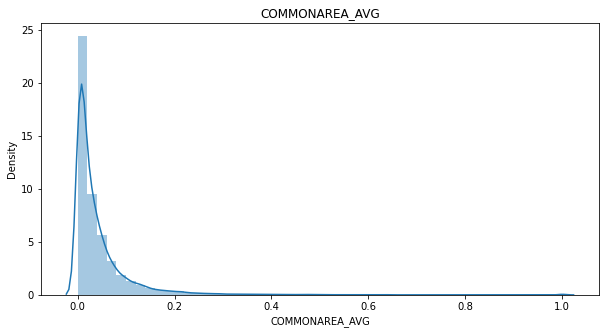

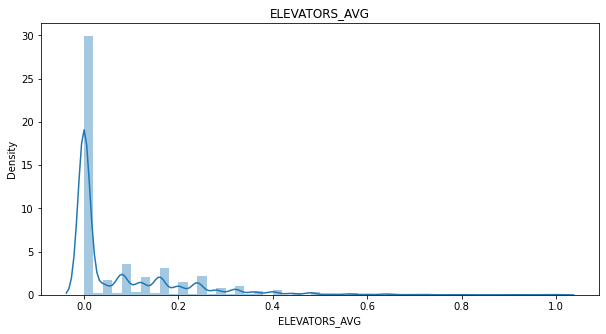

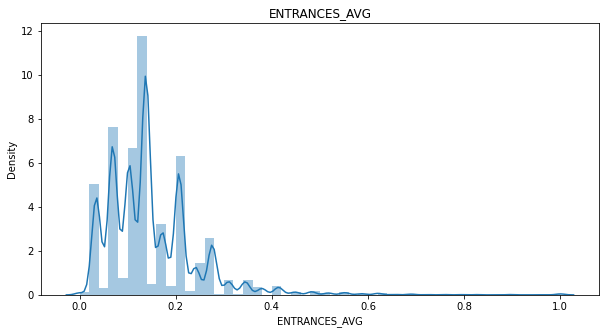

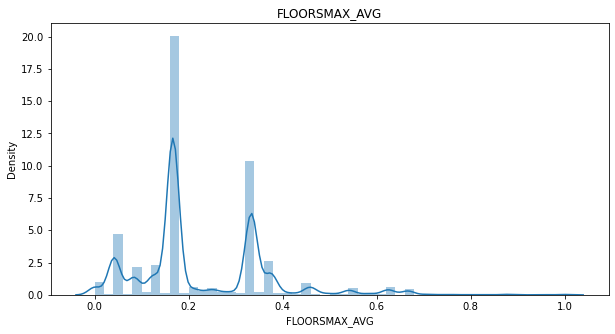

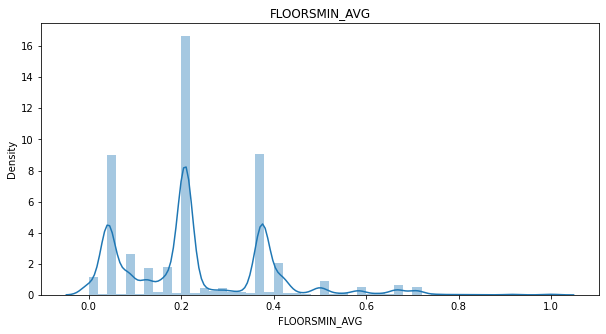

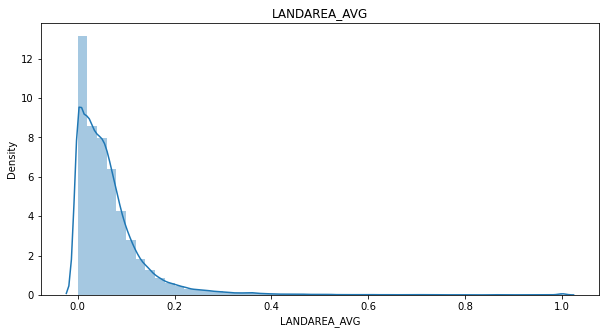

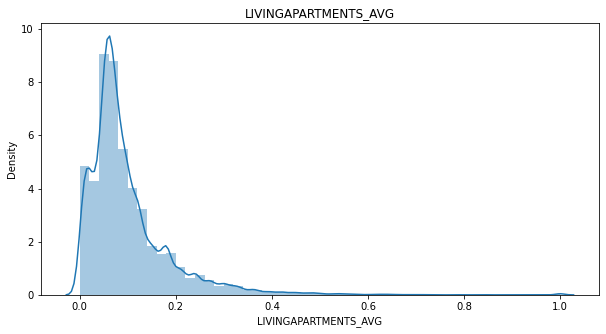

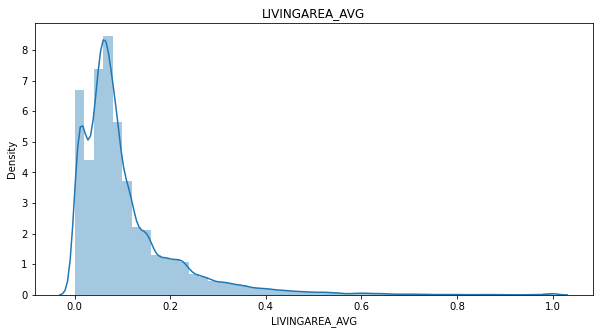

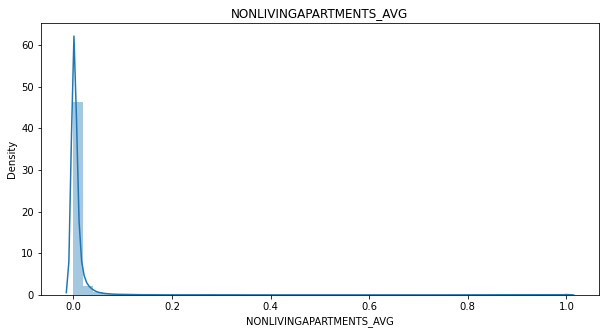

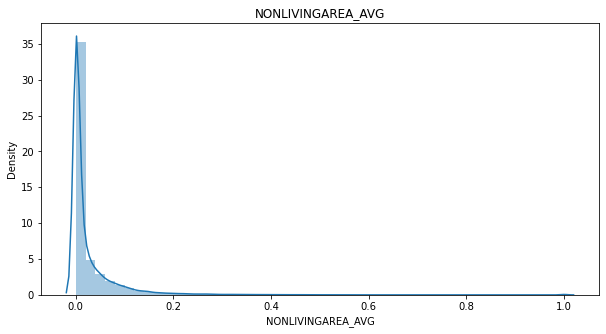

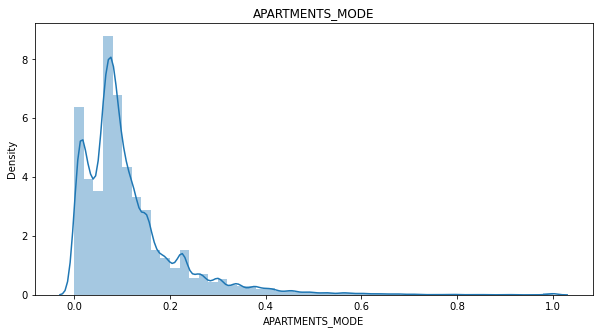

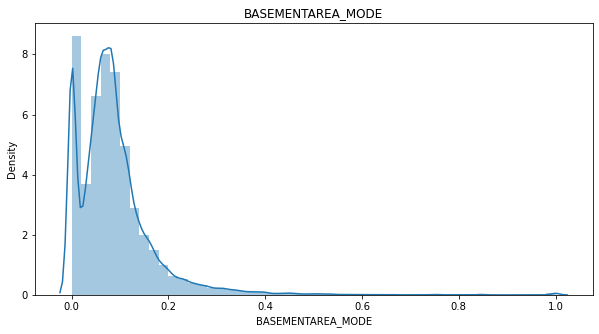

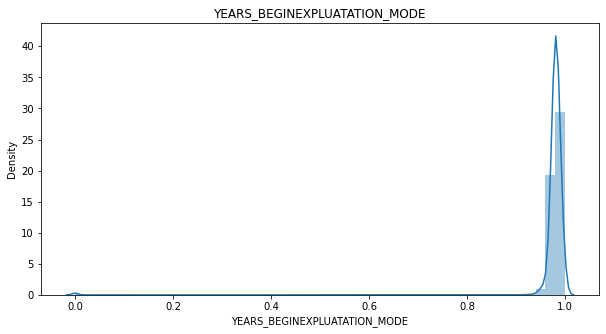

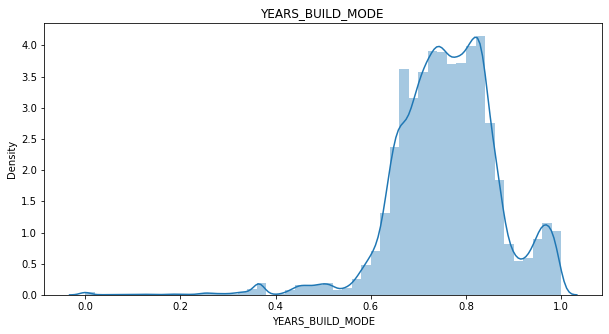

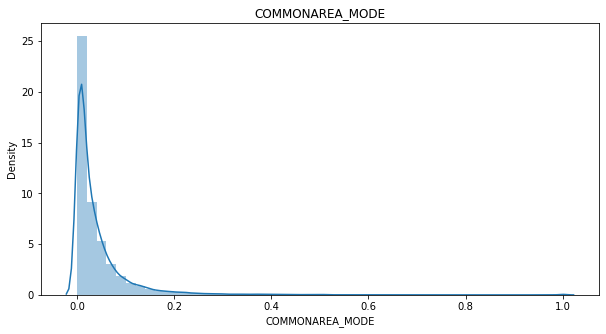

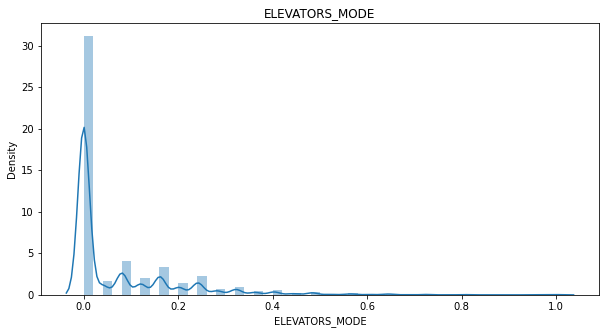

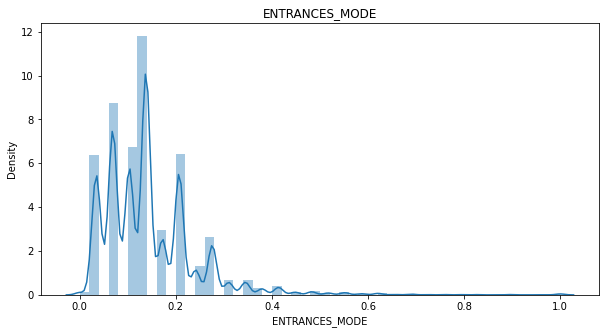

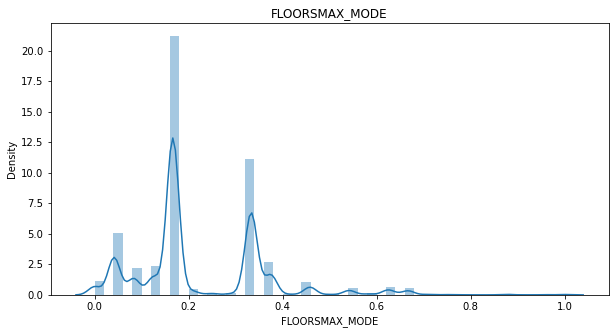

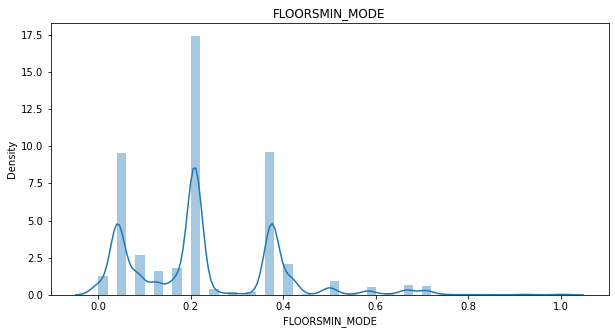

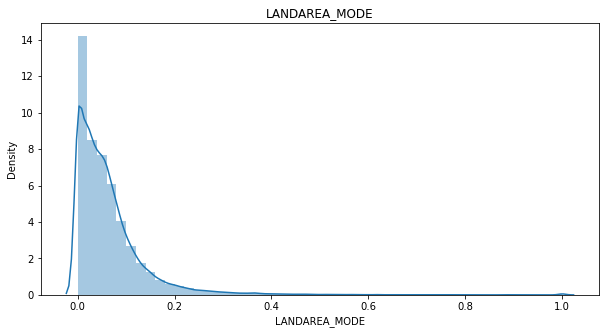

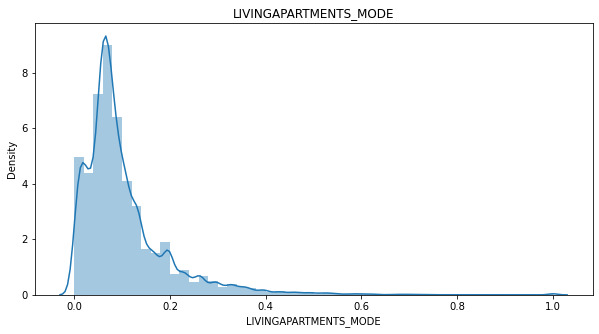

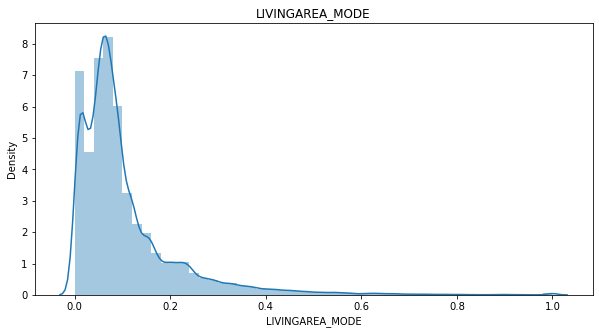

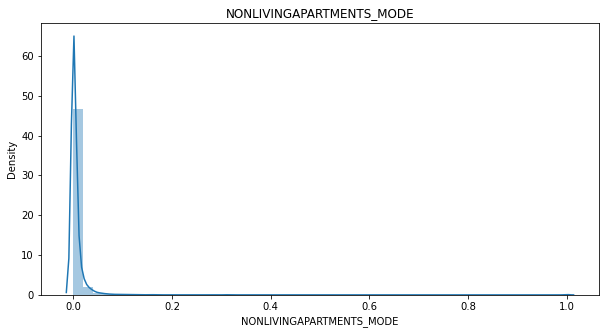

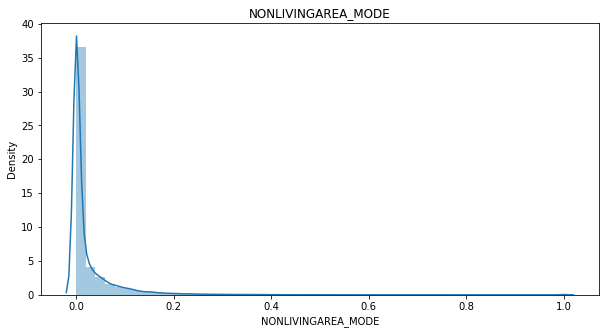

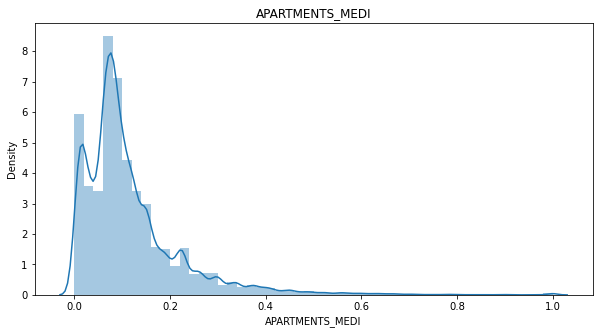

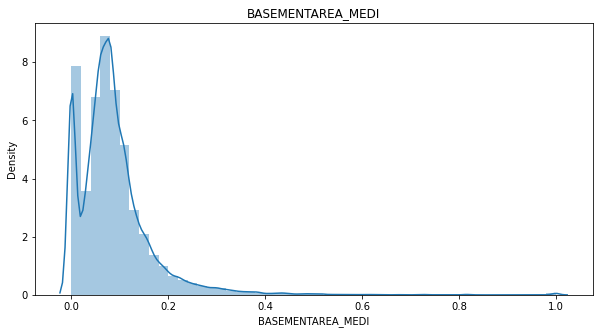

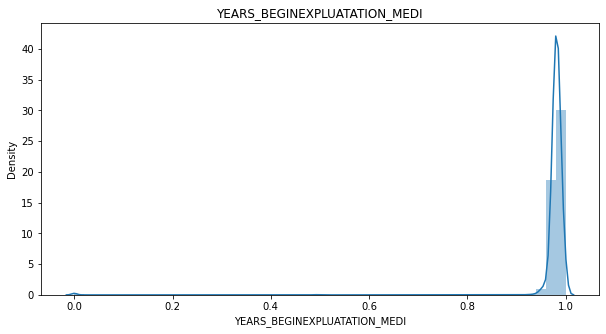

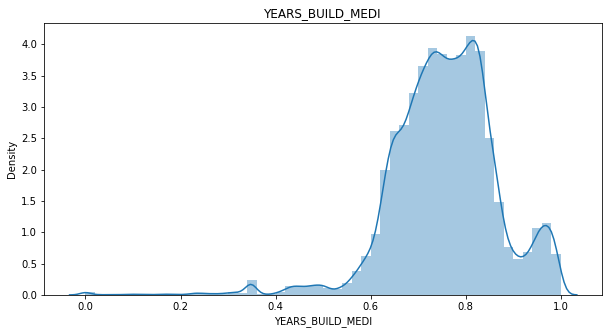

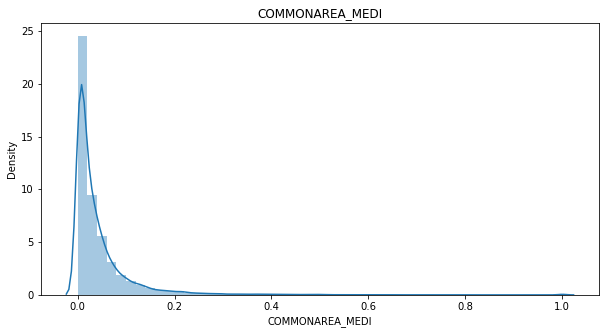

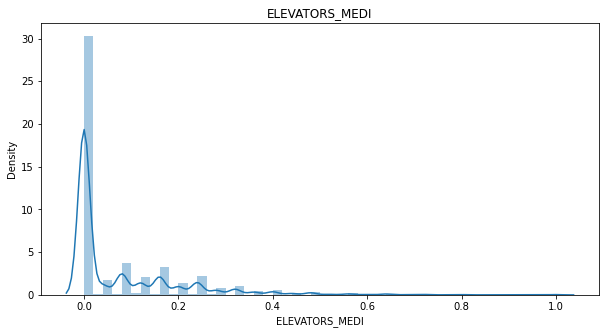

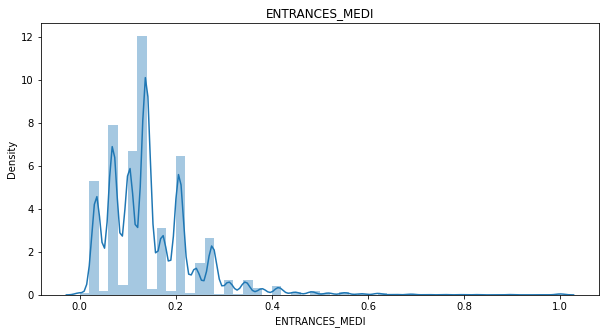

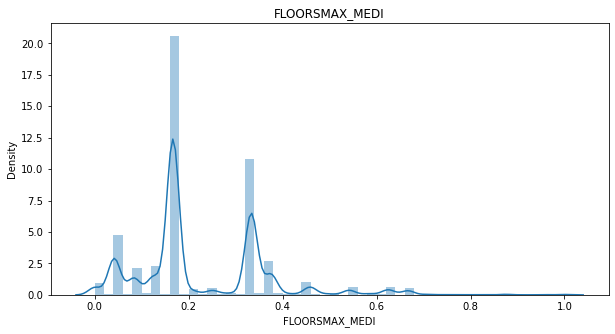

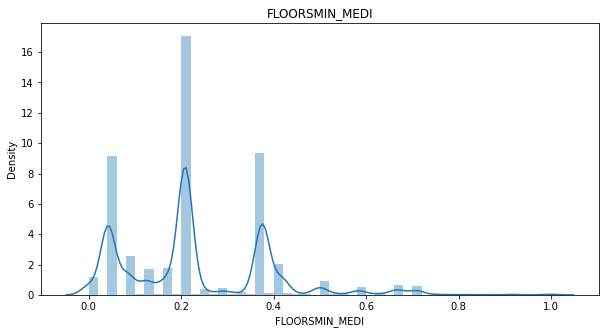

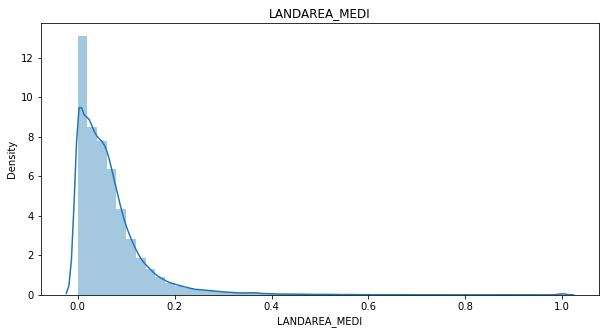

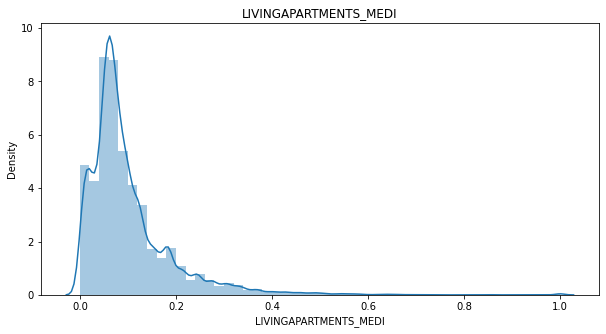

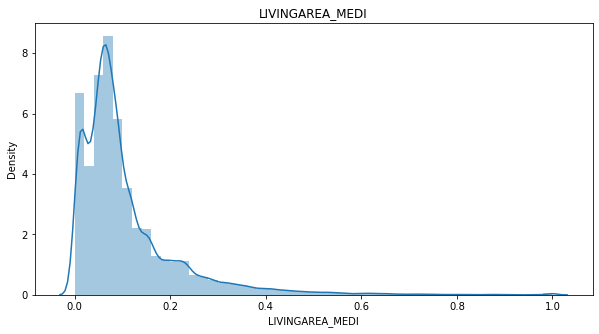

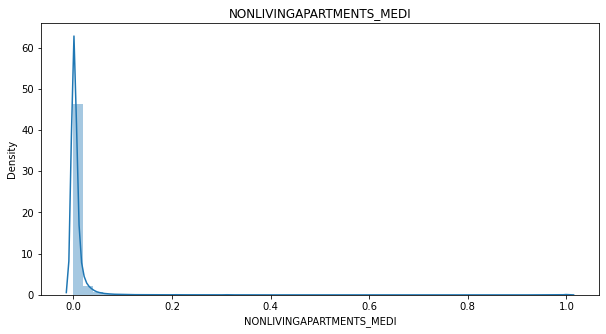

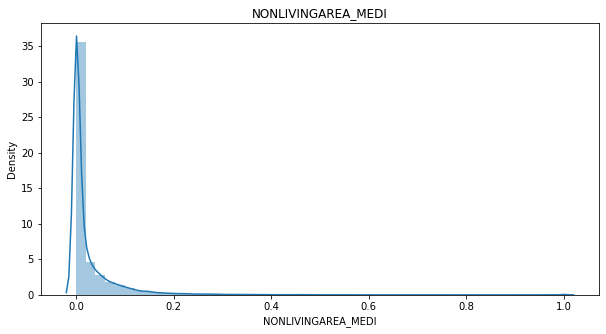

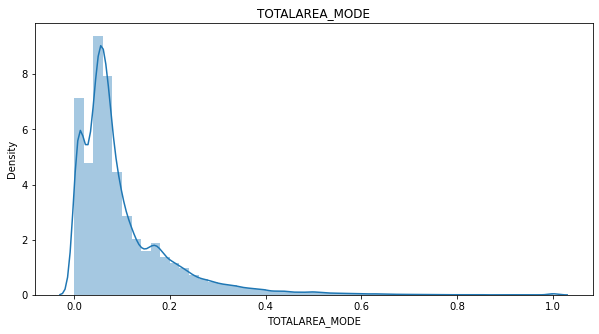

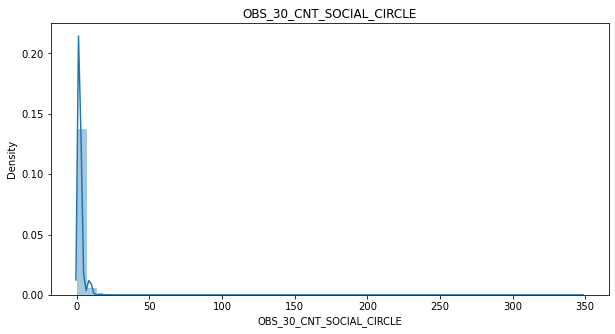

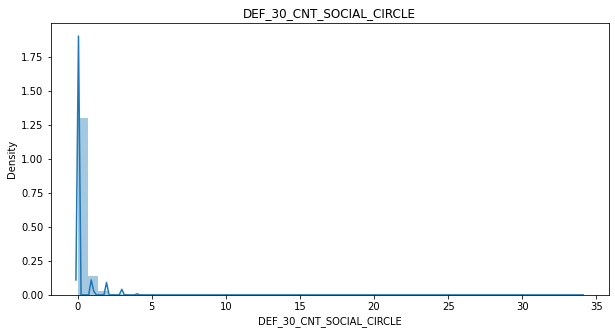

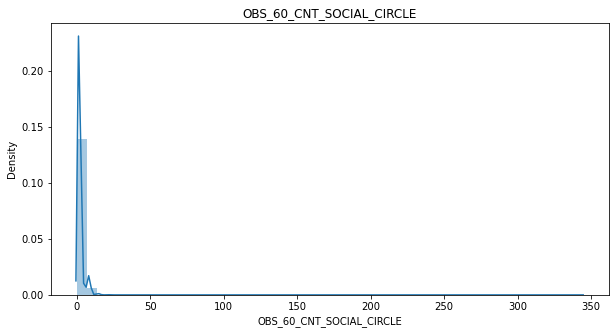

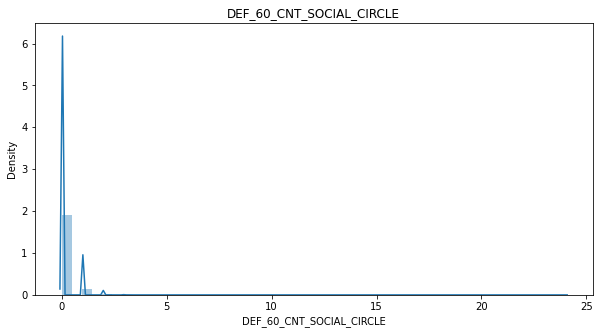

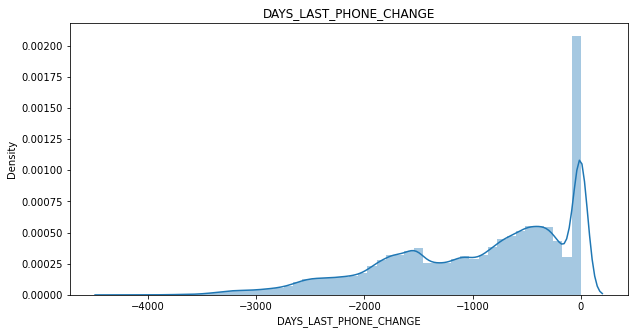

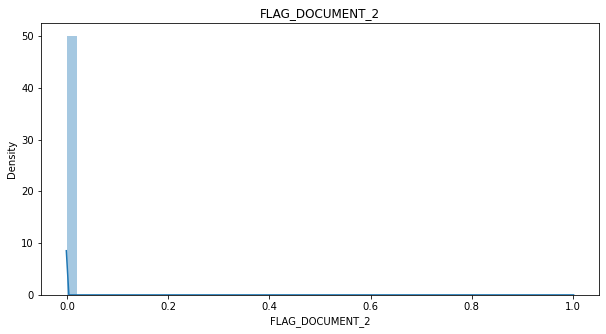

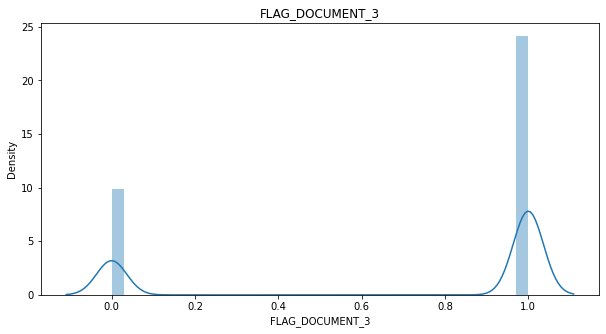

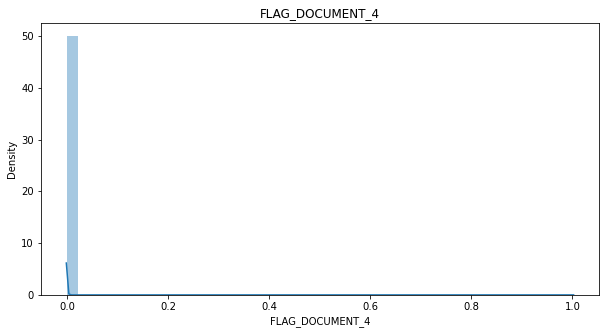

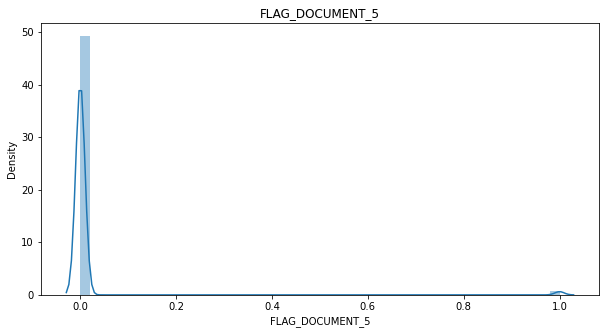

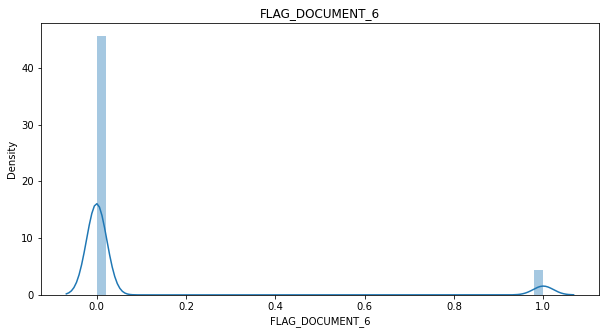

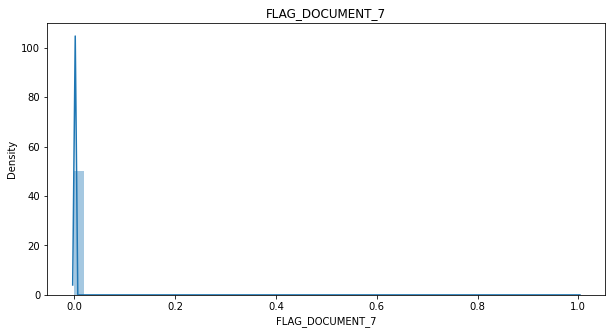

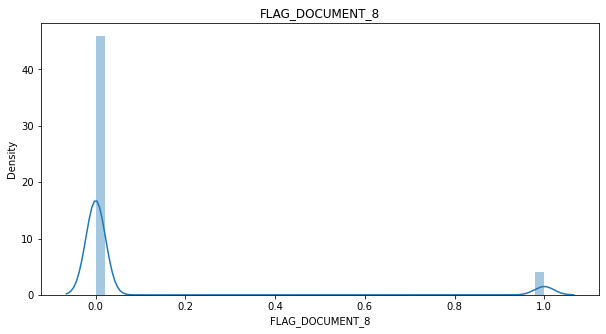

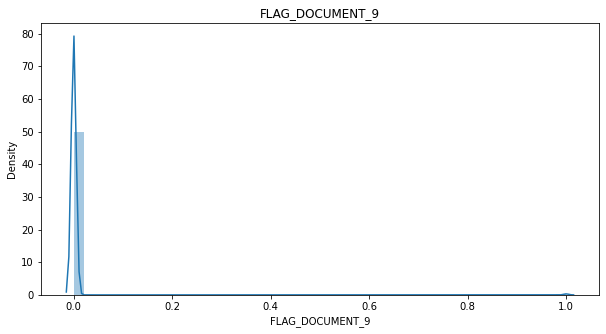

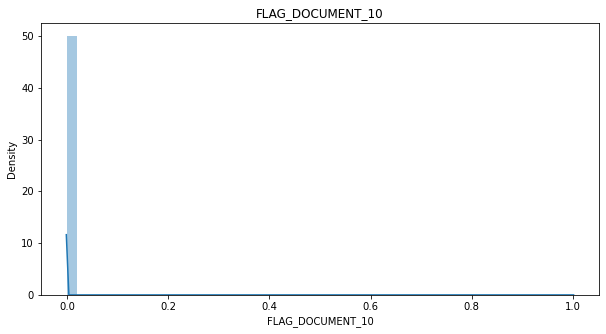

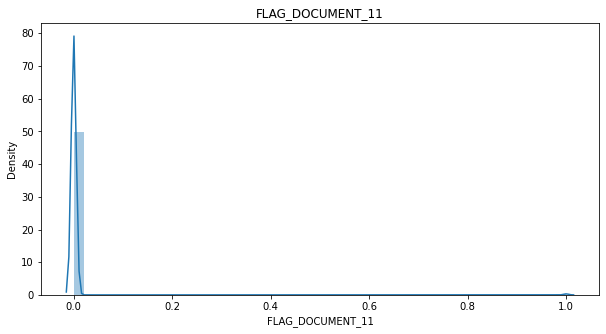

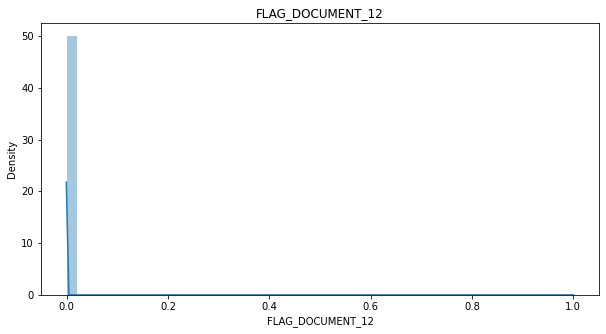

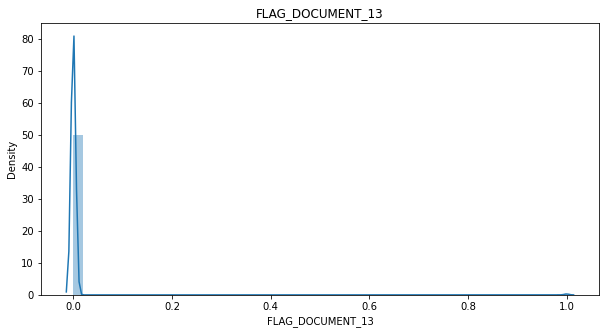

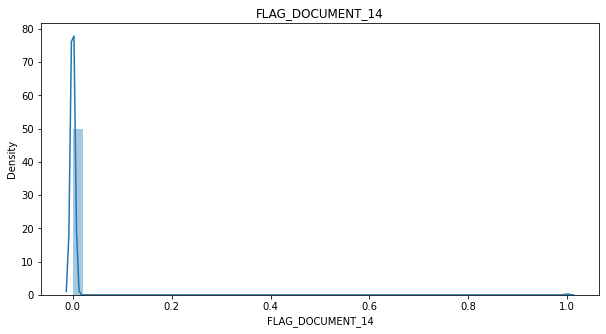

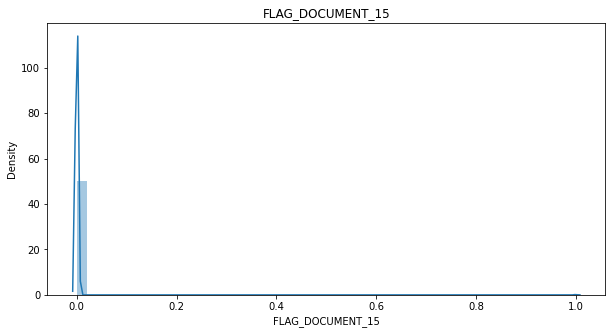

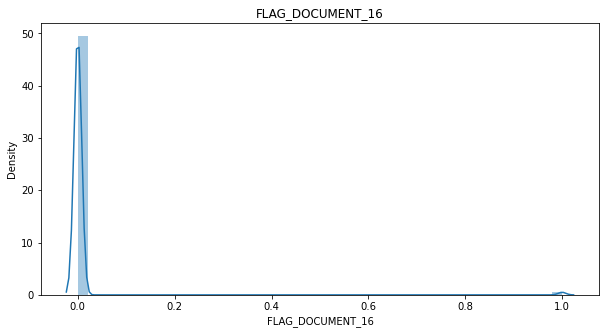

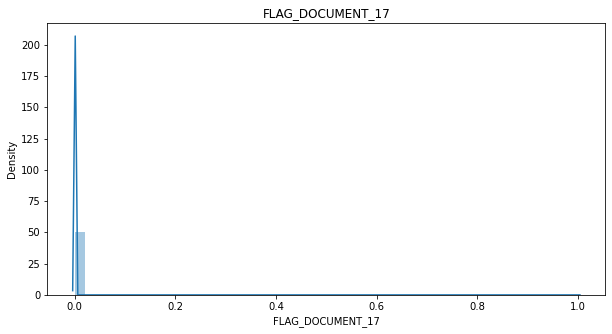

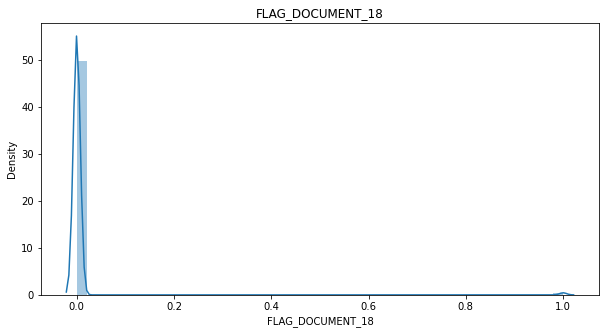

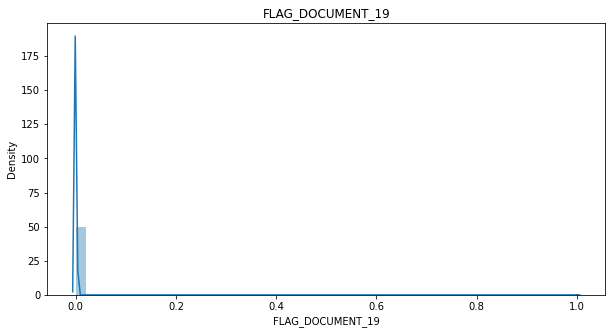

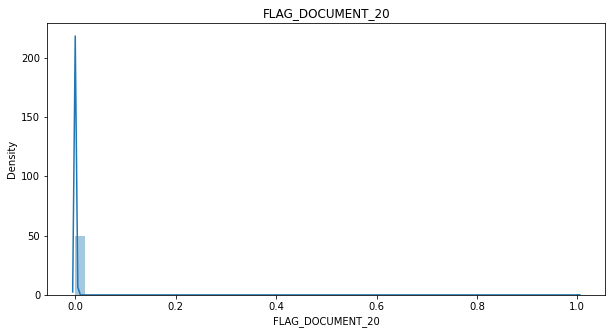

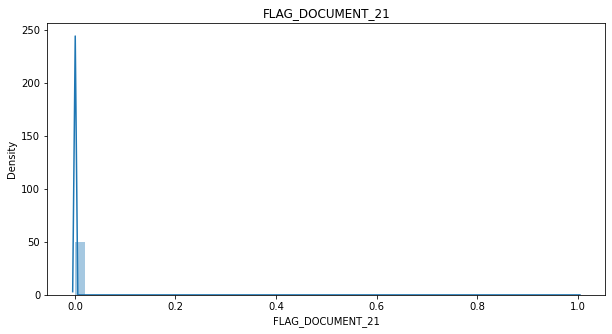

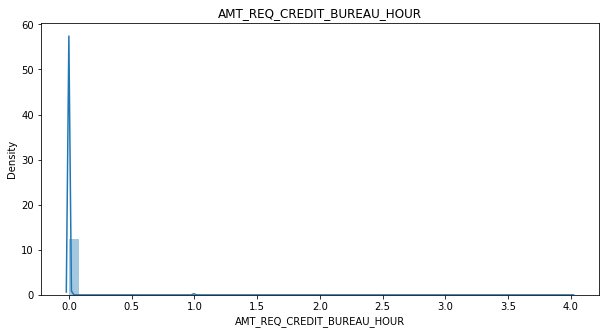

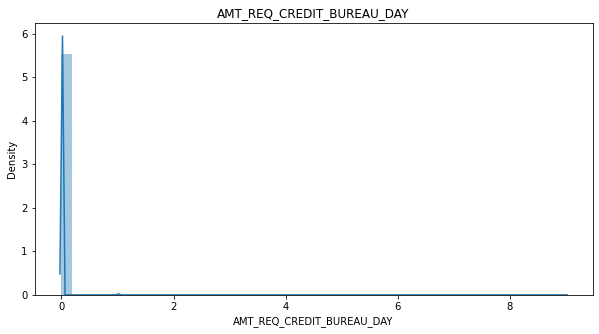

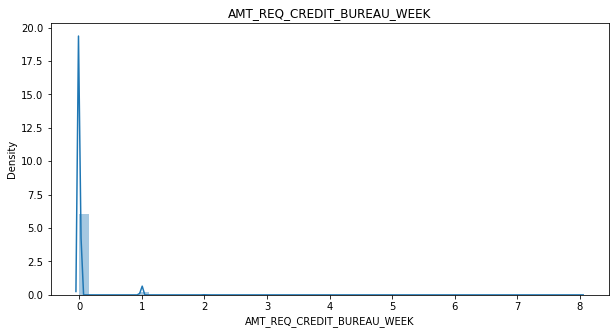

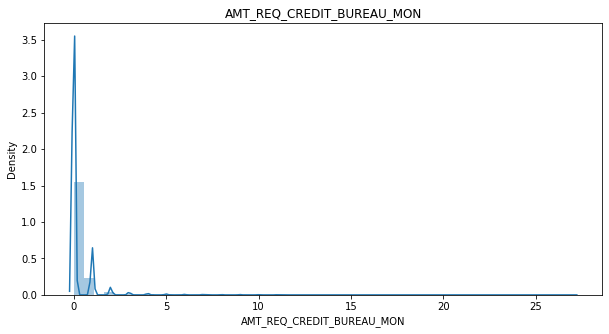

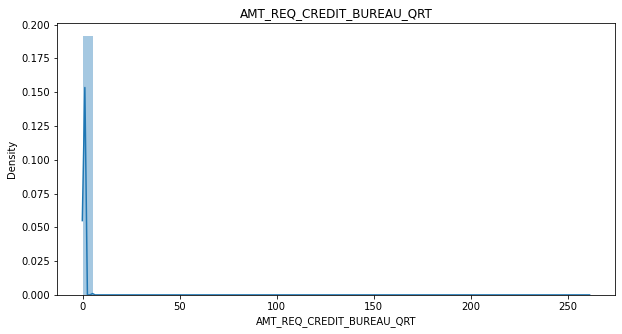

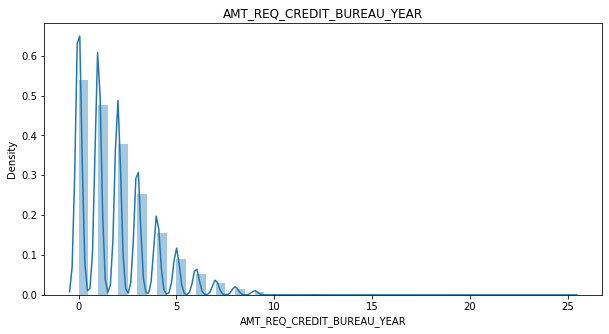

In [20]:
# Analyse de la distribution de mes variables numeriques
for col in application_train.select_dtypes(exclude="object"):
    plt.figure(figsize=(10, 5))
    sns.distplot(application_train[col], kde=True,
                 axlabel=col).set(title=col)

In [27]:
# Analyse de l'unicite des ID 
application_train['SK_ID_CURR'].nunique()

307511

In [32]:
# Analyse des valeurs manquante de ma target 
MISSING_TARGET = round(
    application_train['TARGET'].isna().mean()*100)
print(f' le nombre de ligne avec une target manquante est {MISSING_TARGET}')

# Analyse des % de ma target
application_train['TARGET'].value_counts(normalize = True)*100

 le nombre de ligne avec une target manquante est 0


0    91.927118
1     8.072882
Name: TARGET, dtype: float64

In [33]:
# Analyse des champs alphanumeriques
for col in application_train.select_dtypes('object'):
    print(col, application_train[col].nunique())

NAME_CONTRACT_TYPE 2
CODE_GENDER 3
FLAG_OWN_CAR 2
FLAG_OWN_REALTY 2
NAME_TYPE_SUITE 7
NAME_INCOME_TYPE 8
NAME_EDUCATION_TYPE 5
NAME_FAMILY_STATUS 6
NAME_HOUSING_TYPE 6
OCCUPATION_TYPE 18
WEEKDAY_APPR_PROCESS_START 7
ORGANIZATION_TYPE 58
FONDKAPREMONT_MODE 4
HOUSETYPE_MODE 3
WALLSMATERIAL_MODE 7
EMERGENCYSTATE_MODE 2


In [35]:
# je cree une fonction qui permettra d'afficher les % sur le graphique
def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 15)
    plt.show()

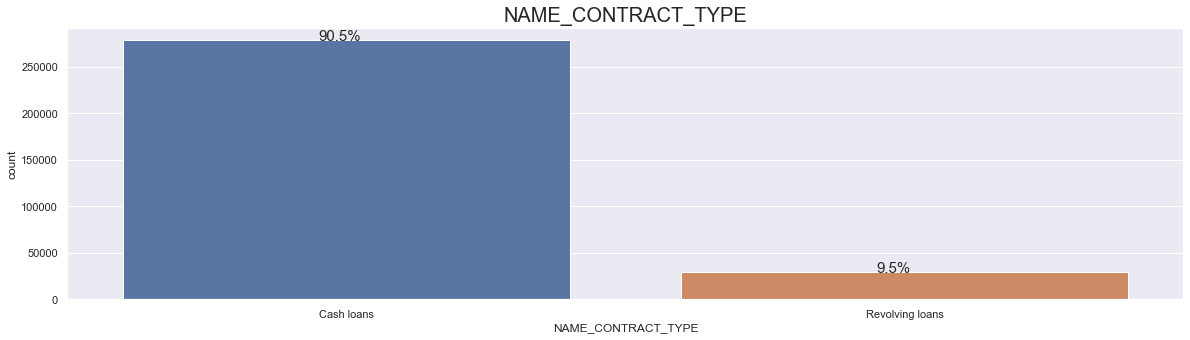

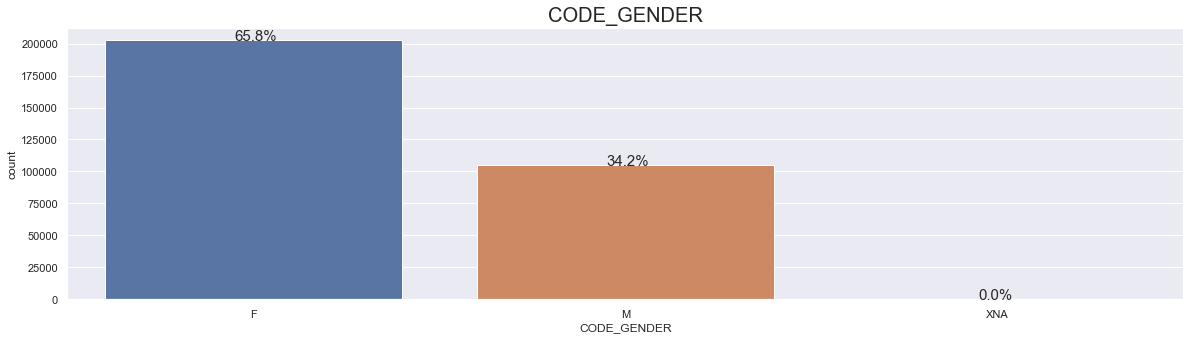

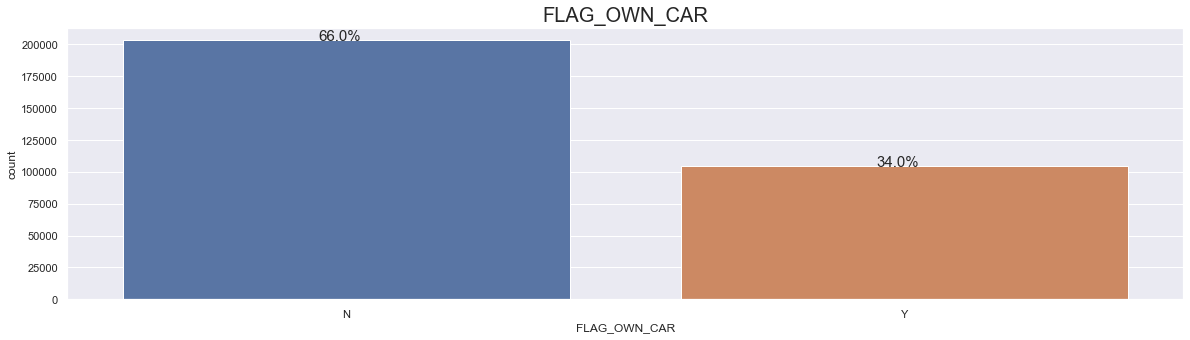

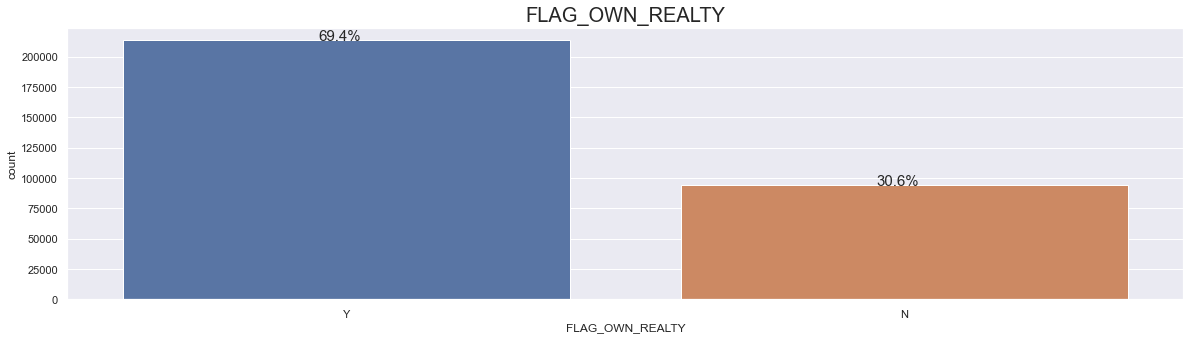

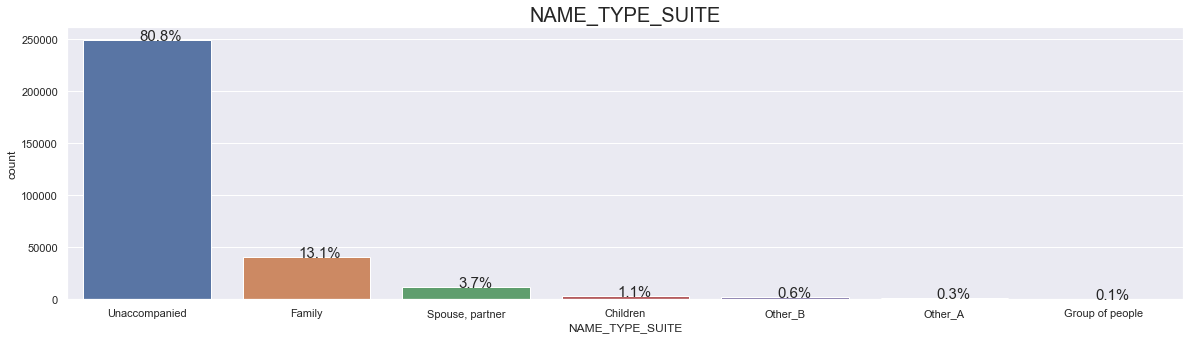

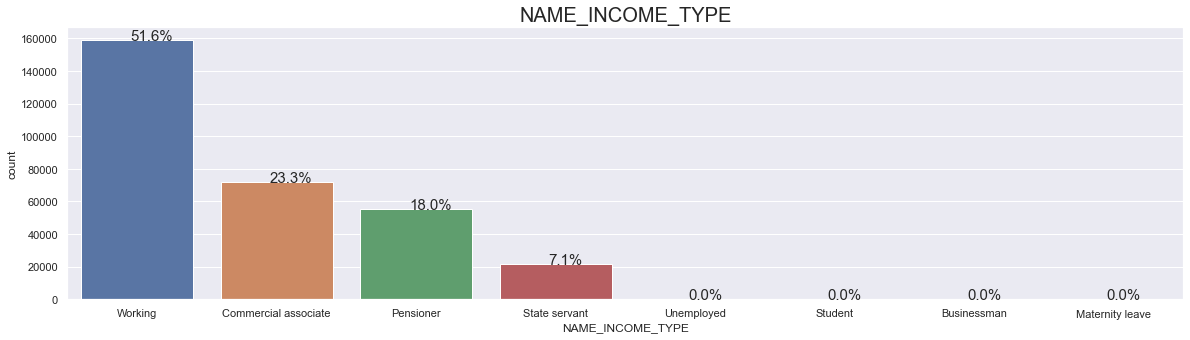

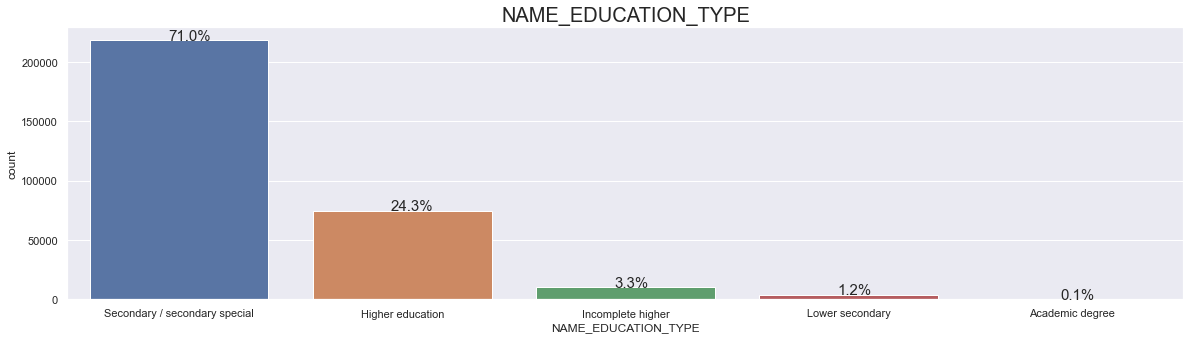

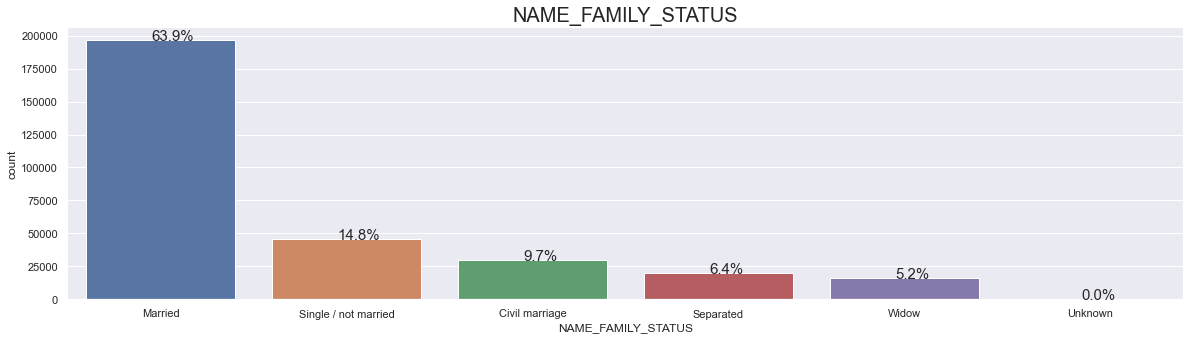

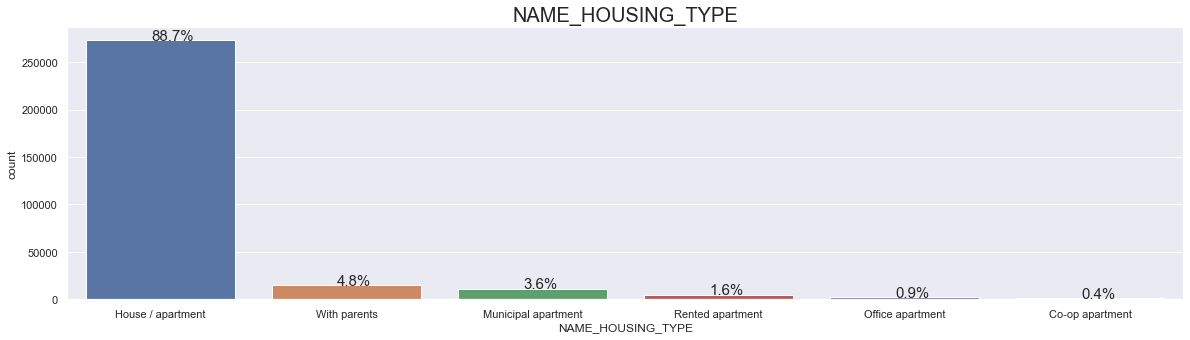

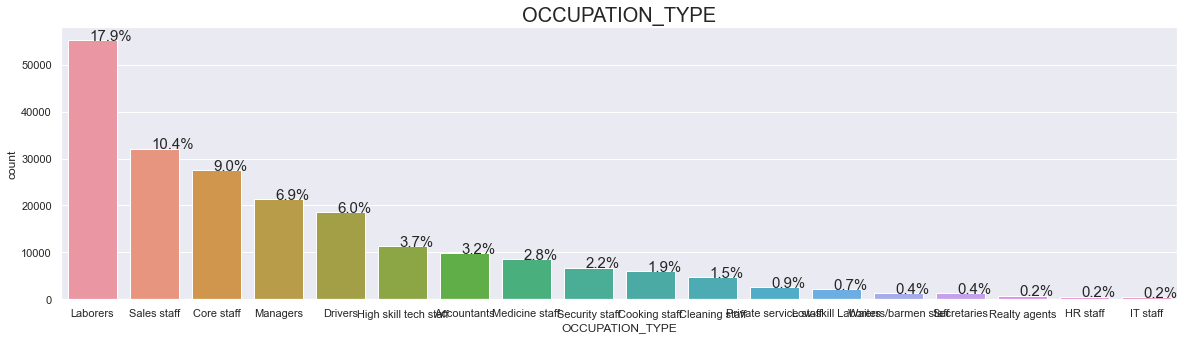

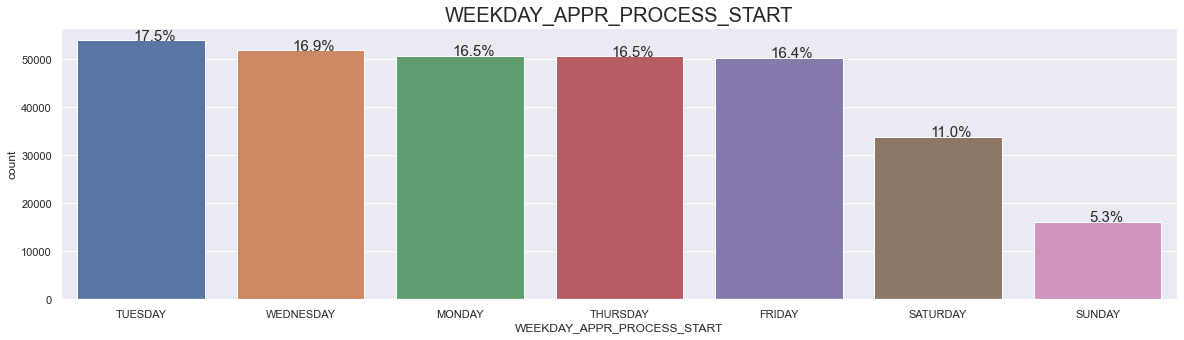

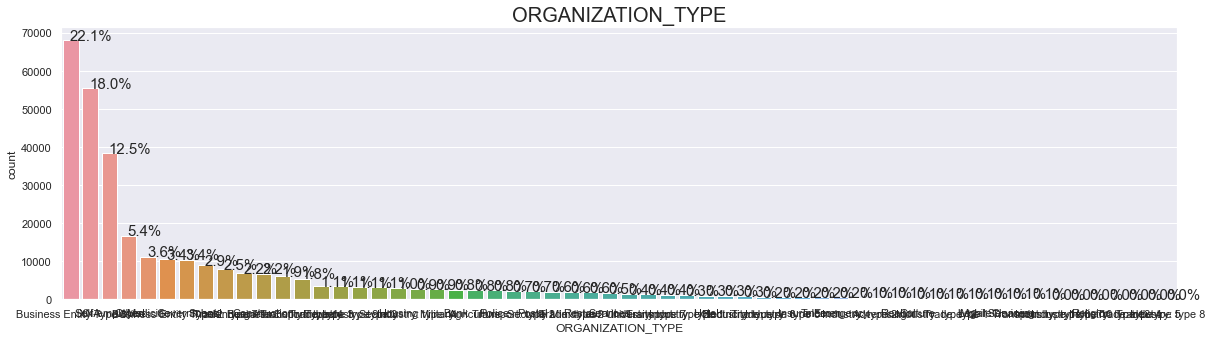

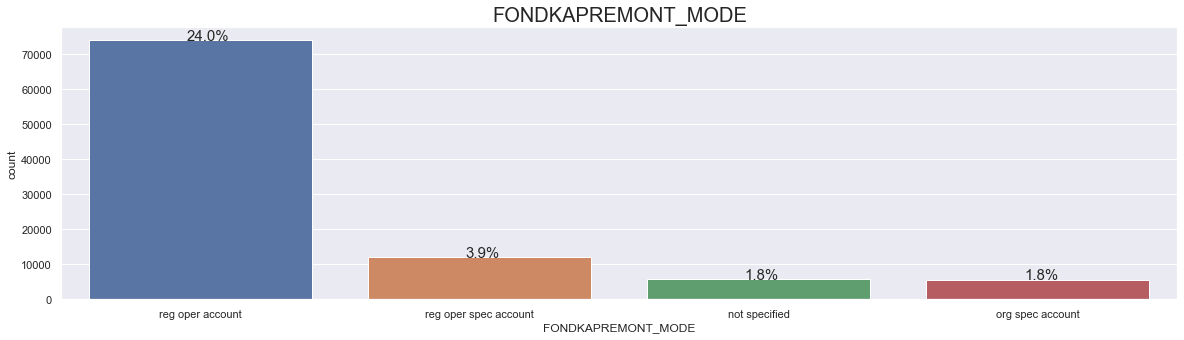

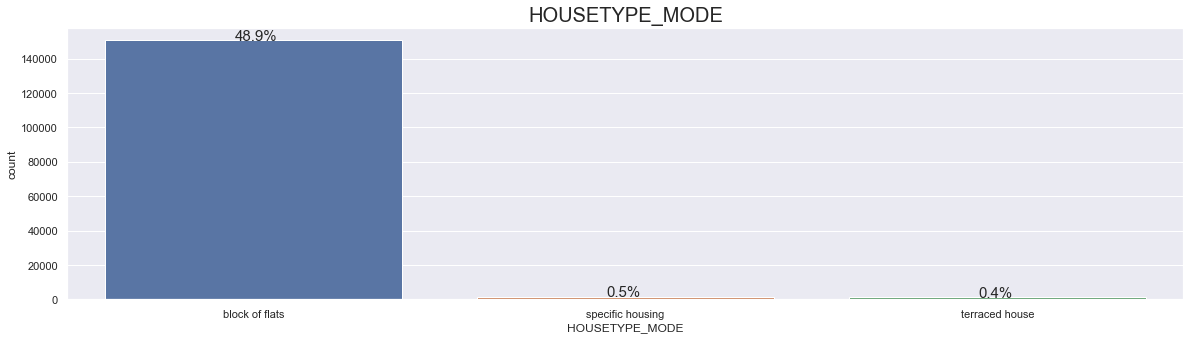

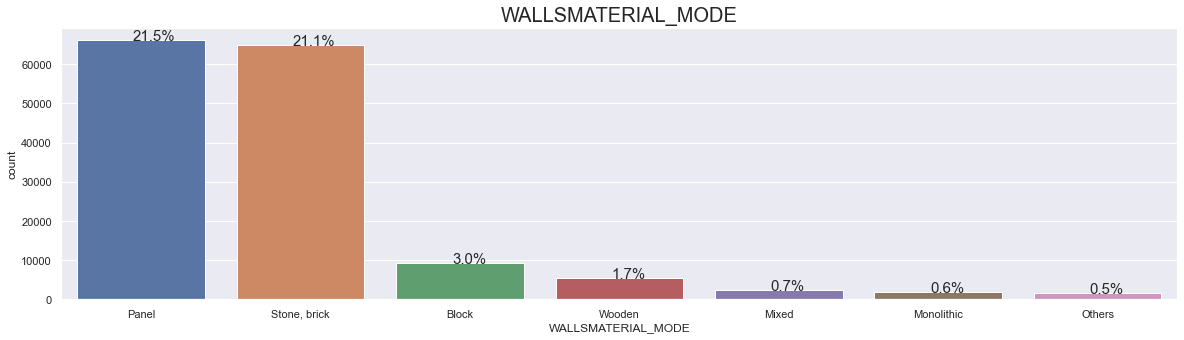

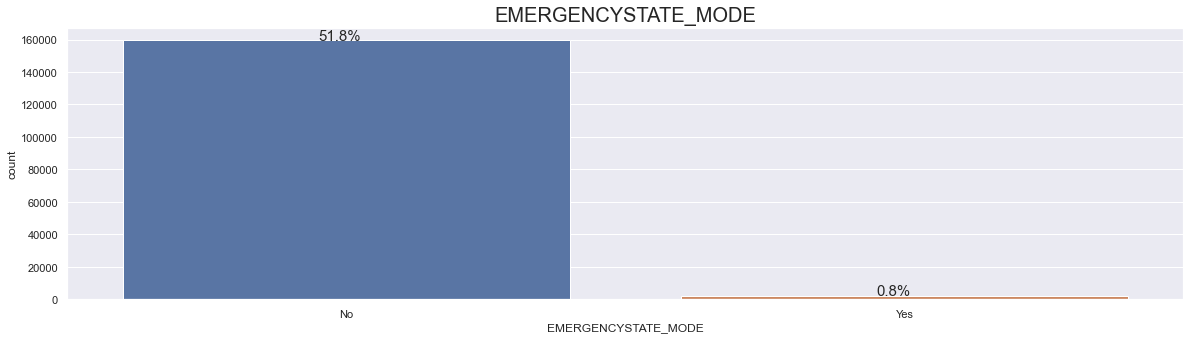

In [39]:
for col in application_train.select_dtypes('object'):
    fig = plt.figure(figsize=(20,5))
    sns.set(style='darkgrid')
    plt.title(col,fontsize=20)
    ax = sns.countplot(x=col, 
                  data=application_train,
                  order = application_train[col].value_counts().index)
    without_hue(ax, application_train[col])

In [ ]:
# Analyse bivariée entre ma target et mes champs 

<AxesSubplot:>

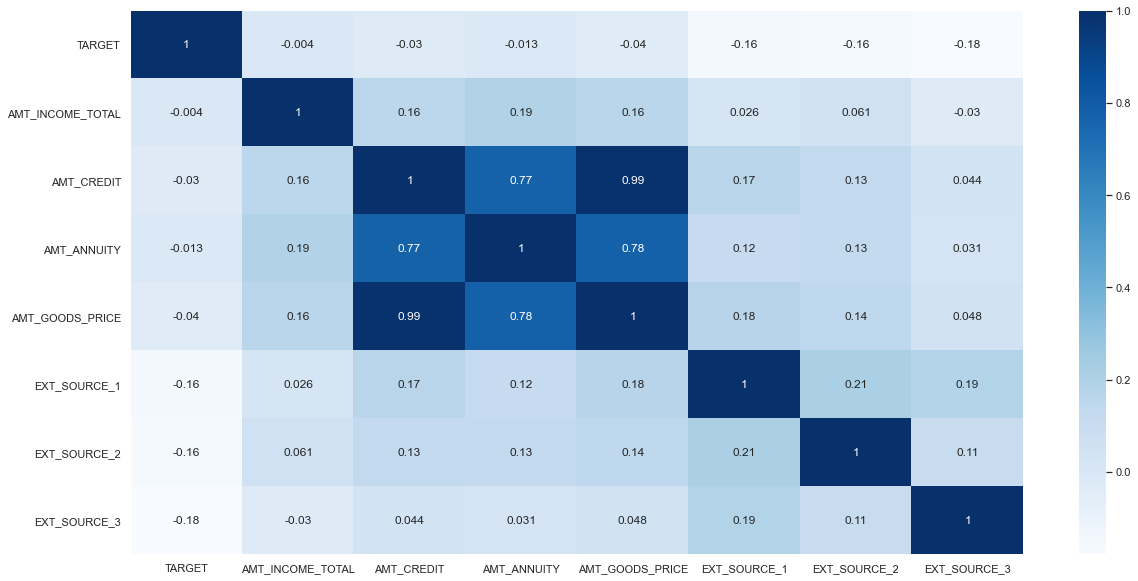

In [43]:
# quanti vs quanti 
plt.figure(figsize=(20, 10))
sns.heatmap(application_train[['TARGET','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE',
                               'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].corr(),cmap="Blues",annot=True)

In [48]:
#Analyse du pnns_groups par nutrigrade
application_train_0 = application_train[application_train['TARGET']== 0]
application_train_1 = application_train[application_train['TARGET']== 1]

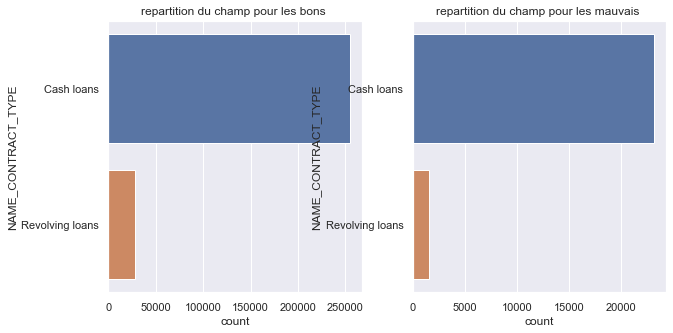

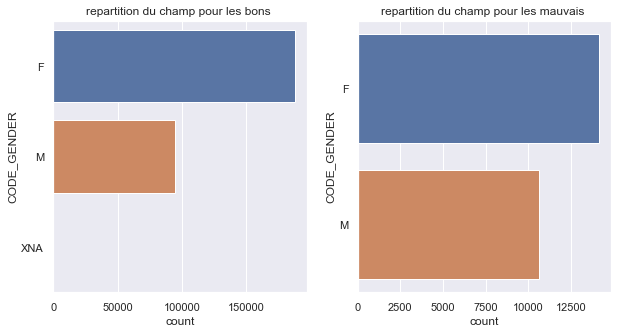

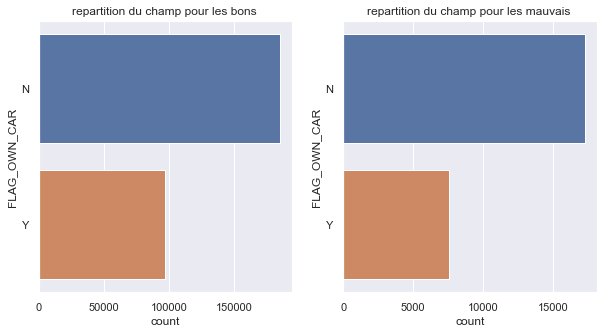

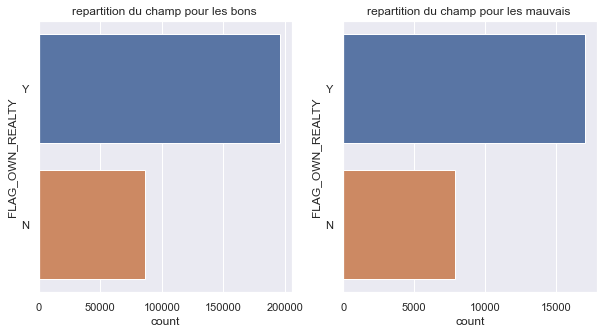

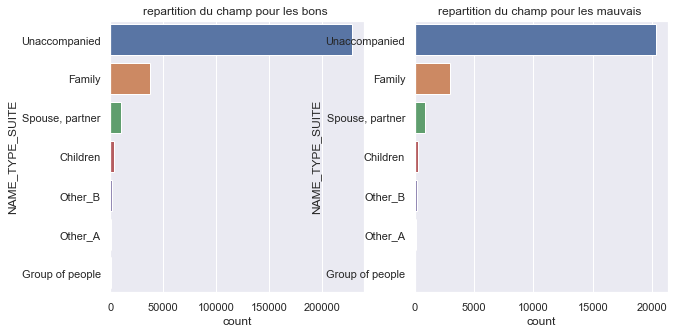

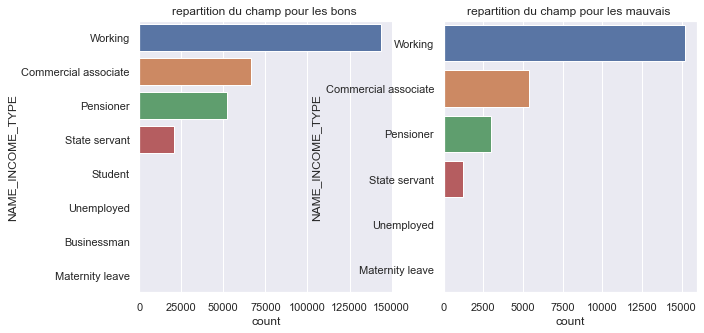

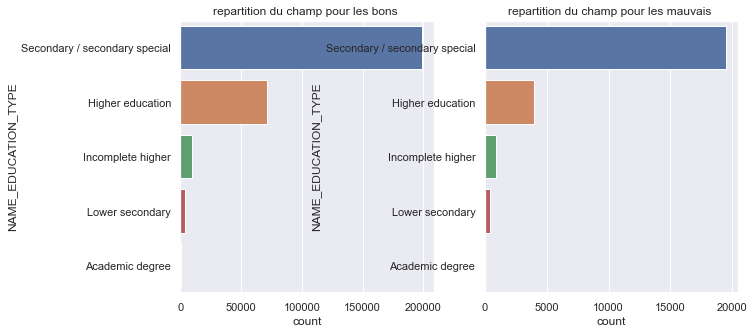

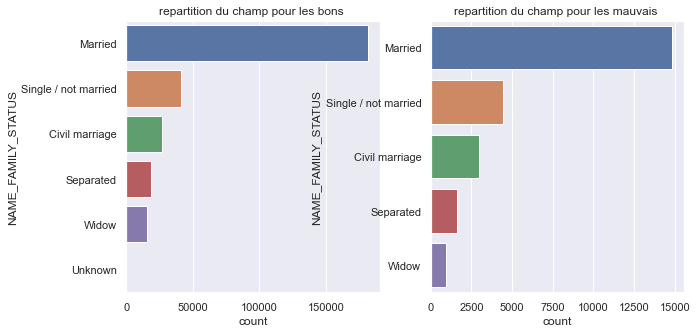

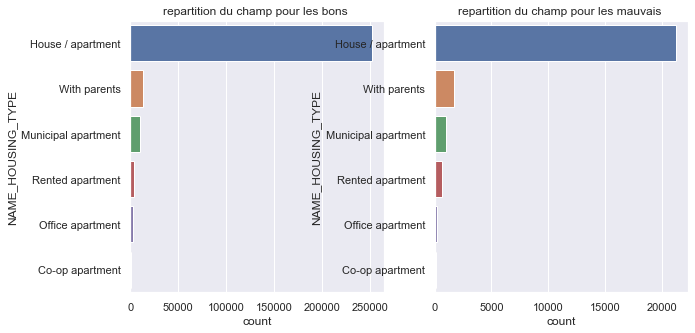

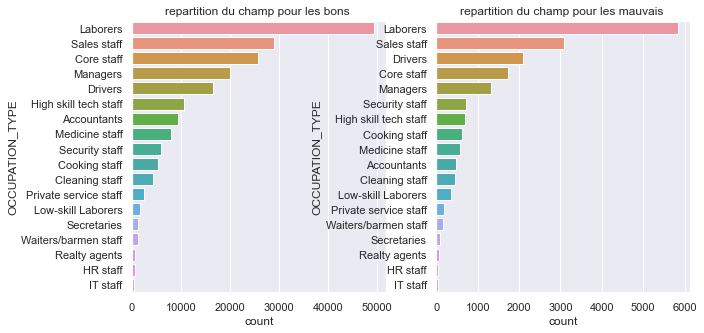

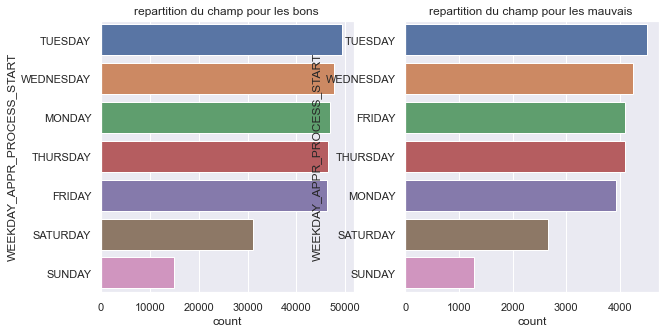

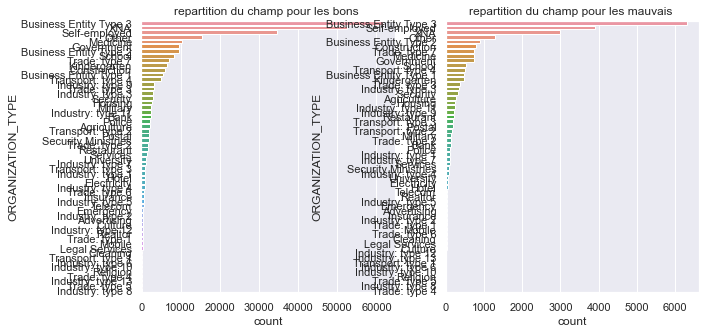

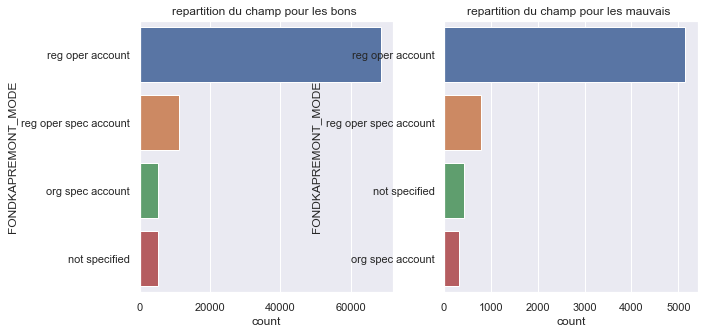

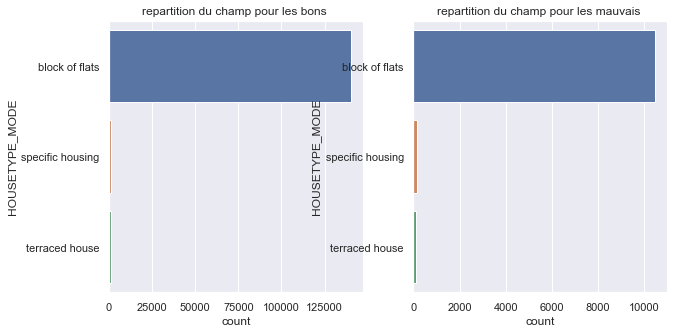

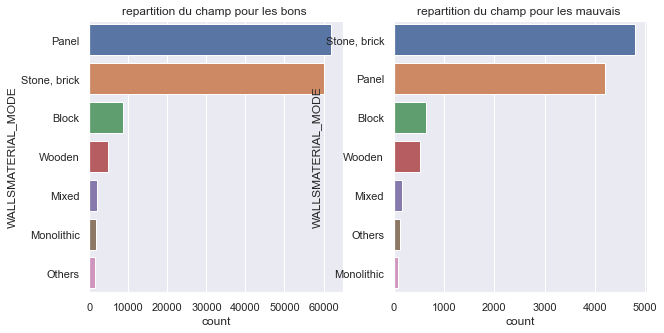

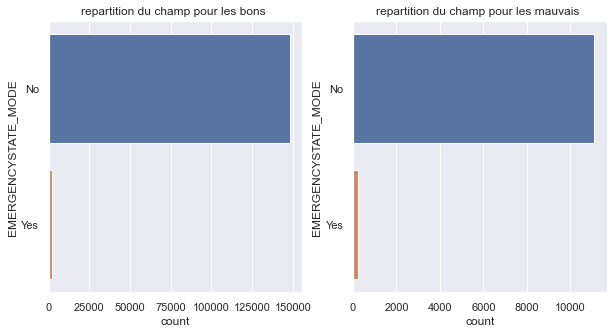

In [58]:

for col in application_train.select_dtypes('object'):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    ax = sns.countplot(y=col, 
                  data=application_train_0,
                  order = application_train_0[col].value_counts().index).set(title ='repartition du champ pour les bons ')
    
    ax = fig.add_subplot(122)
    ax = sns.countplot(y=col, 
                  data=application_train_1,
                  order = application_train_1[col].value_counts().index).set(title ='repartition du champ pour les mauvais ')
    
    plt.show()  

## Feature Engeneering

In [5]:
# Utilisation du Kernel kaggle pour la préparation des données
# Utilisation d'un premier modele de regression

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies


def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv


def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv('../Downloads/application_train.csv', nrows=num_rows)
    print("Train samples: {}".format(len(df)))
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv


def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv('../Downloads/bureau.csv', nrows=num_rows)
    bb = pd.read_csv('../Downloads/bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper()
                              for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg(
        {**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(
        ['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(
        ['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(
        ['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv


def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv('../Downloads/previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg(
        {**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(
        ['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(
        ['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(
        ['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv


def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv('../Downloads/POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(
        ['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

# Preprocess installments_payments.csv


def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv('../Downloads/installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(
        ['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv


def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv('../Downloads/credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper()
                              for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


def main(debug=False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        return df


In [6]:
# Application de l'ensemble du traitement - le train sample correspond à mes données de travail
with timer("Full model run"):
    df = main()

Train samples: 307511
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 24s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 33s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 15s
Installments payments df shape: (339587, 26)
Process installments payments - done in 33s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 18s
Full model run - done in 128s


In [7]:
# Analyse du dataframe crée
df.shape

(307507, 797)

In [8]:
# je regarde toutes les colonnes de mon dataframe
pd.set_option('display.max_columns', df .shape[1])
df.head()

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002       1            0             0                0   
1      100003       0            1             0                1   
2      100004       0            0             1                0   
3      100006       0            1             0                0   
4      100007       0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461         -637.0            -3648.0   
1                    0.003541      -16765        -1188.0            -1186.0   
2                    0.010032      -19046         -225.0            -4260.0   
3                    0.008019      -19005        -3039.0            -9833.0   
4                    0.028663      -19932        -3038.0            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   
3                 1           0           0              2.0   
4                 1           0           0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   
1                       0                        0      0.311267   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262949      0.139376          0.0247            0.0369   
1      0.622246           

In [ ]:
#Controle du format de mes données 
df.info()

## Analyse exploratoire

### Analyse du dataframe

In [ ]:
# creation d'une fonction de comptage pour les valeurs manquantes
def missing_data(df):    
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data=missing_data[missing_data["Total"]>0]
    print (missing_data.shape)
    return missing_data

In [ ]:
# creation d'une fonction d'imputation pour les valeurs manquantes par la moyenne
def imputation_nan(df):
    imputer = SimpleImputer(strategy='median')
    for i in df.columns:
            df[i] = imputer.fit_transform(df.loc[:, [i]].values)
    return df

In [11]:
# Analyse des valeurs manquantes
# il y'a 616 colonnes ayant des valeurs manquantes
# ces valeurs manquantes seront remplis avec notre fonction d'imputation
missing_data(df)

(616, 2)


Total    Percent
REFUSED_AMT_DOWN_PAYMENT_MAX    262339  85.311554
REFUSED_AMT_DOWN_PAYMENT_MEAN   262339  85.311554
REFUSED_AMT_DOWN_PAYMENT_MIN    262339  85.311554
REFUSED_RATE_DOWN_PAYMENT_MEAN  262339  85.311554
REFUSED_RATE_DOWN_PAYMENT_MAX   262339  85.311554
...                                ...        ...
ANNUITY_INCOME_PERC                 12   0.003902
AMT_ANNUITY                         12   0.003902
INCOME_PER_PERSON                    2   0.000650
CNT_FAM_MEMBERS                      2   0.000650
DAYS_LAST_PHONE_CHANGE               1   0.000325

[616 rows x 2 columns]

In [12]:
# Traitement des valeurs infinies
# je passe les valeurs -inf à 0 et inf à NaN
inf_cols = df.columns.to_series()[np.isinf(df).any()] # colonne contenant des inf
inf_index = df.index[np.isinf(df).any(1)] # index des inf
print(inf_cols,inf_index)
for col in (inf_cols): 
    df.loc[df[col]== np.inf,col]= 0
    df.loc[df[col]== -np.inf,col]= np.nan

PREV_APP_CREDIT_PERC_MAX          PREV_APP_CREDIT_PERC_MAX
REFUSED_APP_CREDIT_PERC_MAX    REFUSED_APP_CREDIT_PERC_MAX
INSTAL_PAYMENT_PERC_MAX            INSTAL_PAYMENT_PERC_MAX
dtype: object Int64Index([  5687,  60477,  79077,  89018,  98509, 126768, 128791, 140426,
            152087, 167136, 199103, 201086, 236164, 238381, 272829, 277962,
            287300, 292852, 305373],
           dtype='int64')


In [13]:
# Controle de la bonne execution du traitement des inf
df.loc[[5687,  60477,  79077,  89018,  98509, 126768, 128791, 140426,
            152087, 167136, 199103, 201086, 236164, 238381, 272829, 277962,
            287300, 292852, 305373],["PREV_APP_CREDIT_PERC_MAX", "PREV_APP_CREDIT_PERC_MAX",
"REFUSED_APP_CREDIT_PERC_MAX", "REFUSED_APP_CREDIT_PERC_MAX",
"INSTAL_PAYMENT_PERC_MAX","INSTAL_PAYMENT_PERC_MAX"]]

PREV_APP_CREDIT_PERC_MAX  PREV_APP_CREDIT_PERC_MAX  \
5687                    1.000000                  1.000000   
60477                   1.276243                  1.276243   
79077                   1.111111                  1.111111   
89018                   1.567712                  1.567712   
98509                   1.118620                  1.118620   
126768                  1.111111                  1.111111   
128791                       NaN                       NaN   
140426                  1.111111                  1.111111   
152087                  1.011024                  1.011024   
167136                  1.250038                  1.250038   
199103                  0.909918                  0.909918   
201086                  0.000000                  0.000000   
236164                  1.011021                  1.011021   
238381                  1.134431                  1.134431   
272829                  1.111111                  1.111111   
277962                  0.907737                  0.907737   
287300                  0.938086                  0.938086   
292852                  1.614431                  1.614431   
305373                  1.034851                  1.034851   

        REFUSED_APP_CREDIT_PERC_MAX  REFUSED_APP_CREDIT_PERC_MAX  \
5687                        1.00000                      1.00000   
60477                           NaN                          NaN   
79077                       1.00000                      1.00000   
89018                           NaN                          NaN   
98509                       1.11862                      1.11862   
126768                          NaN                          NaN   
128791                          NaN                          NaN   
140426                          NaN                          NaN   
152087                          NaN                          NaN   
167136                          NaN                          NaN   
199103                          NaN                          NaN   
201086                      0.00000                      0.00000   
236164                          NaN                          NaN   
238381                          NaN                          NaN   
272829                      0.90665                      0.90665   
277962                          NaN                          NaN   
287300                          NaN                          NaN   
292852                      1.00000                      1.00000   
305373                      1.00000                      1.00000   

        INSTAL_PAYMENT_PERC_MAX  INSTAL_PAYMENT_PERC_MAX  
5687                        0.0                      0.0  
60477                       0.0                      0.0  
79077                       0.0                      0.0  
89018                       0.0                      0.0  
98509                       0.0                      0.0  
126768                      0.0                      0.0  
128791                      0.0                      0.0  
140426                      0.0                      0.0  
152087                      0.0                      0.0  
167136                      0.0                      0.0  
199103                      0.0                      0.0  
201086                      1.0                      1.0  
236164                      0.0                      0.0  
238381                      0.0                      0.0  
272829                      0.0                      0.0  
277962                      0.0                      0.0  
287300                      0.0                      0.0  
292852                      0.0                      0.0  
305373                      0.0                      0.0

In [35]:
# Remplissage des valeurs manquantes avec ma fonction d'imputation
df2 = imputation_nan(df)
# j'enregistre les resultats car l'éxécution est longue
dump(df2, open('df2.pkl', 'wb'))

NameError: name 'imputation_nan' is not defined

### Analyse univariée

In [18]:
# Chargement des données 
import pickle
with open('df2.pkl', 'rb') as features_data:
    df2 = pickle.load(features_data)

FileNotFoundError: [Errno 2] No such file or directory: 'df2.pkl'

In [4]:
df2 = pd.read_csv("C:/Users/akabe/Downloads/df2_final.csv", sep=',')

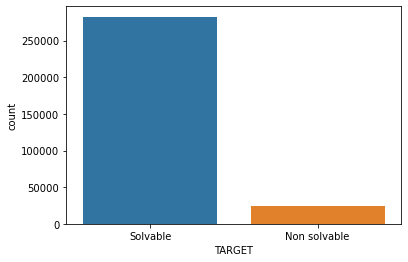

In [5]:
# Analyse visuelle de ma target
# on remarque bien un déséquilibre entre les modalités
sns.countplot(df2['TARGET'],label='count')
g = sns.countplot(df2['TARGET'])
g.set_xticklabels(['Solvable','Non solvable'])
plt.show()

In [ ]:
# Analyse chiffrée de ma target
df2['TARGET'].values_count(normalize = True)

In [3]:
# Stats descriptives globales de mes données
df2.describe()

SK_ID_CURR        TARGET    CODE_GENDER   FLAG_OWN_CAR  \
count  307507.000000  307507.00000  307507.000000  307507.000000   
mean   278181.527256       0.08073       0.658352       0.340106   
std    102790.132982       0.27242       0.474263       0.473745   
min    100002.000000       0.00000       0.000000       0.000000   
25%    189146.500000       0.00000       0.000000       0.000000   
50%    278203.000000       0.00000       1.000000       0.000000   
75%    367143.500000       0.00000       1.000000       1.000000   
max    456255.000000       1.00000       1.000000       1.000000   

       FLAG_OWN_REALTY   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count    307507.000000  307507.000000      3.075070e+05  3.075070e+05   
mean          0.306331       0.417047      1.687977e+05  5.990286e+05   
std           0.460970       0.722119      2.371246e+05  4.024926e+05   
min           0.000000       0.000000      2.565000e+04  4.500000e+04   
25%           0.000000       0.000000      1.125000e+05  2.700000e+05   
50%           0.000000       0.000000      1.471500e+05  5.135310e+05   
75%           1.000000       1.000000      2.025000e+05  8.086500e+05   
max           1.000000      19.000000      1.170000e+08  4.050000e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  ...  \
count  307507.000000     3.075070e+05  ...   
mean    27108.580714     5.383178e+05  ...   
std     14493.522125     3.692898e+05  ...   
min      1615.500000     4.050000e+04  ...   
25%     16524.000000     2.385000e+05  ...   
50%     24903.000000     4.500000e+05  ...   
75%     34596.000000     6.795000e+05  ...   
max    258025.500000     4.050000e+06  ...   

       CC_NAME_CONTRACT_STATUS_Signed_MAX  \
count                       307507.000000   
mean                             0.013954   
std                              0.117301   
min                              0.000000   
25%                              0.000000   
50%                              0.000000   
75%                              0.000000   
max                              1.000000   

       CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
count                        307507.000000   
mean                              0.001056   
std                               0.017032   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       CC_NAME_CONTRACT_STATUS_Signed_SUM  CC_NAME_CONTRACT_STATUS_Signed_VAR  \
count                       307507.000000                       307507.000000   
mean                             0.032321                            0.000861   
std                              0.705313                            0.010872   
min                              0.000000                            0.000000   
25%                              0.000000                            0.000000   
50%                              0.000000                            0.000000   
75%                              0.000000                            0.000000   
max                             62.000000                            0.500000   

       CC_NAME_CONTRACT_STATUS_nan_MIN  CC_NAME_CONTRACT_STATUS_nan_MAX  \
count                         307507.0                         307507.0   
mean                               0.0                              0.0   
std                                0.0                              0.0   
min                                0.0                              0.0   
25%                                0.0                              0.0   
50%                                0.0                              0.0   
75%                                0.0                              0.0   
max                                0.0                              0.0   

       CC_NAME_CONTRACT_STATUS_nan_MEAN  CC_NAME_CONTRACT_STATUS_nan_SUM  \
count                

### Reduction de dimension

In [24]:
# préparation des données pour l'ACP
from sklearn import decomposition
from sklearn import preprocessing
X = df2.drop('TARGET',axis=1).values

In [25]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
pca = decomposition.PCA()
pca.fit(X_scaled)

PCA()

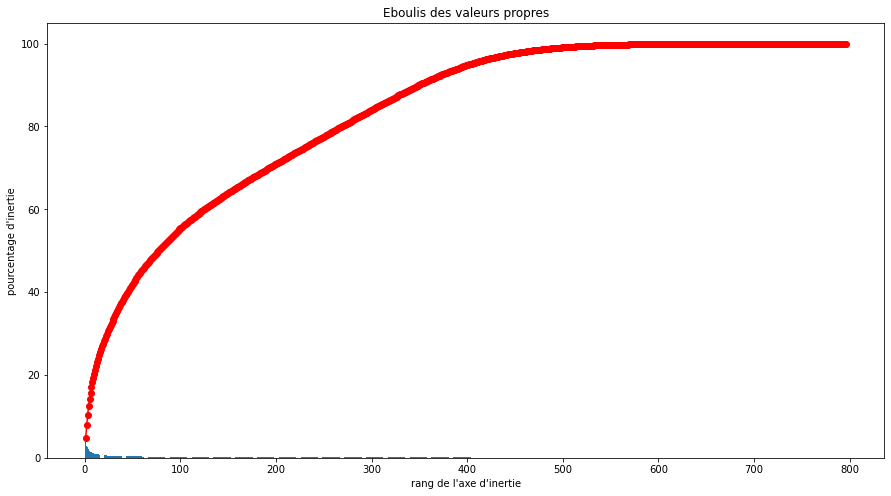

In [26]:
# Eboulis des valeurs propres
def display_scree_plot(pca):
    plt.figure(figsize=(15, 8))
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
display_scree_plot(pca)

In [35]:
# Determination du nombre de composantes ayant un pouvoir explicatif acceptable
# je garderai les variables qui permettent d'expliquer 99% de mon modèle finale
from sklearn import decomposition
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_.sum())
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

0.9901039374336442
Dimensions dataset après réduction PCA :  (307507, 496)


## Modelisation 

In [8]:
# échantillonnage de mon jeu de données
# je travaille avec 10% de mon jeu de données
from sklearn.utils import resample
df2_sample = resample(df2, n_samples= 30000, replace=False,random_state=42)
# controle des poids après echantillonnage
print(df2['TARGET'].value_counts(normalize = True),df2_sample['TARGET'].value_counts(normalize = True))

0.0    0.91927
1.0    0.08073
Name: TARGET, dtype: float64 0.0    0.917933
1.0    0.082067
Name: TARGET, dtype: float64


In [9]:
# Creation du train et test split
from sklearn.model_selection import train_test_split
X = df2_sample.drop('TARGET',axis=1)
y = df2_sample['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,stratify=y, random_state=42)
print("X_train shape: {}, X_test shape: {},y_train shape: {}, y_test shape: {}".format(X_train.shape, X_test.shape,y_train.shape, y_test.shape))

X_train shape: (21000, 796), X_test shape: (9000, 796),y_train shape: (21000,), y_test shape: (9000,)


In [46]:
# 2 methodes pour traiter le desequilibre des donnees
#Cost-Sensitive Learning
# Sampling Methods : SMOTE 

# Premier test de modelisation
# parametrage des hyperparametres des modeles
# chargement des modèles à tester
# tester lightGBM - 0,77 en moyenne AUC
# https://medium.com/@silvaan/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a
# https://machinelearningmastery.com/cost-sensitive-logistic-regression/


# deuxieme test de modelisation avec class_weight
# parametrage des hyperparametres des modeles
# chargement des modèles à tester
# tester lightGBM - 0,77 en moyenne AUC
# https://medium.com/@silvaan/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a
# https://machinelearningmastery.com/cost-sensitive-logistic-regression/
# tester lightgbm
# utilisation Apprentissage sensible aux coûts
# regarder Adacost - methode ensembliste sensible aux couts - https://github.com/joelprince25/adacost/blob/master/example/adacost_example.ipynb
# https://machinelearningmastery.com/xgboost-for-imbalanced-classification/ - Best posweight for XGBOOSTCLF
# Pour chque max_depth, ,j'ai un score optimal
#https://www.kaggle.com/code/michalbrezk/xgboost-classifier-and-hyperparameter-tuning-85
# colab https://www.bing.com/videos/search?q=impoter+un+fichier+pickle+sur+google+colab&&view=detail&mid=34B8E4E53A4297C040A934B8E4E53A4297C040A9&rvsmid=5C27369542431C71D6CC5C27369542431C71D6CC&FORM=VDQVAP


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import  RandomForestClassifier 
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from collections import Counter
from time import time

# Initialisation de la pipeline des modeles

pipeline_dummy = Pipeline(
    [('standard_scaler', StandardScaler()),('pca', decomposition.PCA(n_components=0.99)), ('Dummy', DummyClassifier(random_state=42))])
pipeline_logistic = Pipeline(
    [('standard_scaler', StandardScaler()),('pca', decomposition.PCA(n_components=0.99)), ('Logistic', LogisticRegression(class_weight='balanced',random_state=42))])
pipeline_RandomForestClf = Pipeline(
    [('standard_scaler', StandardScaler()),('pca', decomposition.PCA(n_components=0.99)), ('RFC', RandomForestClassifier(class_weight='balanced',random_state=42))])
pipeline_LightGBM = Pipeline(
    [('standard_scaler', StandardScaler()),('pca', decomposition.PCA(n_components=0.99)), ('LightGBM', LGBMClassifier(class_weight= "balanced", random_state=42))])


# initialisation des hyperparametres

Param_Dummy = {'Dummy__strategy': ['most_frequent', 'prior', 'stratified', 'uniform', 'constant']}

Param_Logistic = {'Logistic__C': np.logspace(-3, 3, 7),
                  'Logistic__penalty':['l1','l2','elasticnet'],
                  'Logistic__solver':['liblinear','newton-cg', 'lbfgs', 'sag', 'saga'] 
                 }


Param_RandomForestClf = {'RFC__max_depth' : [4,5,10,50],
                         'RFC__min_samples_split': [2, 5, 10],
                         'RFC__min_samples_leaf': [1, 2, 4],
                         'RFC__n_estimators': [100],
                         'RFC__max_leaf_nodes': [10,50]
                        }

Param_LightGBM = {'LightGBM__boosting_type':['gbdt','rf','dart','goss'],
                 'LightGBM__n_estimators':[50,100],
                 'LightGBM__learning_rate': [0.01,0.1, 0.2],
                 'LightGBM__num_leaves':[30],
                 'LightGBM__max_depth':[5,8,10],
                 'LightGBM__min_split_gain':[0.01,0.1, 0.2],  
                 }

# Definition de mes mesures de performances du modele
scorers = {
    "auc": "roc_auc",
    "f1" : "f1"
}


# Initialisation de mes GridSearchCV et utilisation de l'AUC
# indiquer le nombre de crossvalidation
cv = 5
Grid_Dummy = GridSearchCV(pipeline_dummy, Param_Dummy, cv=cv, scoring=scorers, refit = "auc")
Grid_Logistic = GridSearchCV(pipeline_logistic, Param_Logistic, cv=cv, scoring=scorers, refit = "auc")
Grid_RandomForestClf = GridSearchCV(pipeline_RandomForestClf, Param_RandomForestClf, cv=cv, scoring=scorers, refit = "auc")
GridLightGBM = GridSearchCV(pipeline_LightGBM,Param_LightGBM, cv=cv, scoring=scorers, refit = "auc")

# Creation de la liste des Grid
Grids = [Grid_Logistic,Grid_RandomForestClf,Grid_Dummy,GridLightGBM]

In [47]:
# Modélisation avec mes différents modèles
Grids = [Grid_Dummy,Grid_Logistic,Grid_RandomForestClf, 
         GridLightGBM]
grid_dict = {0: 'dummyClf',
             1: 'Logistic',
             2: 'RandomForestClf',
             3: 'LightGBM'
             }

tab = pd.DataFrame(columns=['AUC_validation_set', 'F1_validation_set', 'mean_fit_time', 'predict_time', 'params', 'split0_AUC_score', 'split1_AUC_score',
                            'split2_AUC_score', 'split3_AUC_score', 'split4_AUC_score'])
# Fit the grid search objects
print('Performing model optimizations...')
for idx, gs in enumerate(Grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Condition pour le lightGBM
    if grid_dict[idx] == 'LightGBM':
        gs.fit(X_train.to_numpy(), y_train.to_numpy())
        # creation de la grille des resultats
        Grille = pd.DataFrame(gs.cv_results_)
        z = pd.DataFrame(Grille, index=[gs.best_index_])
        # temps pour predire
        start = time()
        clf_probs = gs.predict_proba(X_test.to_numpy())
        predict_time = time()-start
    else:
        # fit pour les autres modeles hors LightGBM
        gs.fit(X_train, y_train)
        # creation de la grille des resultats
        Grille = pd.DataFrame(gs.cv_results_)
        z = pd.DataFrame(Grille, index=[gs.best_index_])
        # temps pour predire
        start = time()
        clf_probs = gs.predict_proba(X_test)
        predict_time = time()-start
    # creation de mon dictionnaire
    Grille_comparaison = {"AUC_validation_set": list(z["mean_test_auc"]),
                          "F1_validation_set": list(z["mean_test_f1"]),
                          "mean_fit_time": list(z["mean_fit_time"]),
                          "predict_time": predict_time,
                          "params": list(z["params"]),
                          "split0_AUC_score": list(z["split0_test_auc"]),
                          "split1_AUC_score": list(z["split1_test_auc"]),
                          "split2_AUC_score": list(z["split2_test_auc"]),
                          "split3_AUC_score": list(z["split3_test_auc"]),
                          "split4_AUC_score": list(z["split4_test_auc"]),
                          }

    grid_dict[idx] = pd.DataFrame(Grille_comparaison, index=[grid_dict[idx]])
    tab = tab.append(grid_dict[idx], ignore_index=False)

Performing model optimizations...

Estimator: dummyClf

Estimator: Logistic

Estimator: RandomForestClf

Estimator: LightGBM


In [49]:
# parametres du meilleur modele
tab.sort_values(by = "AUC_validation_set",ascending = False)

AUC_validation_set F1_validation_set mean_fit_time  \
Logistic                  0.743841          0.264837     15.054107   
RandomForestClf           0.700136          0.231069     17.693727   
LightGBM                  0.699708          0.236452      5.374742   
dummyClf                       0.5               0.0      2.247293   

                predict_time  \
Logistic            0.462744   
RandomForestClf     0.410901   
LightGBM            0.338885   
dummyClf             0.22195   

                                                            params  \
Logistic         {'Logistic__C': 0.01, 'Logistic__penalty': 'l1...   
RandomForestClf  {'RFC__max_depth': 10, 'RFC__max_leaf_nodes': ...   
LightGBM         {'LightGBM__boosting_type': 'goss', 'LightGBM_...   
dummyClf                      {'Dummy__strategy': 'most_frequent'}   

                split0_AUC_score split1_AUC_score split2_AUC_score  \
Logistic                0.731622         0.756961         0.744949   
RandomForestClf         0.680437         0.699457         0.726109   
LightGBM                0.701126         0.687683         0.711534   
dummyClf                     0.5              0.5              0.5   

                split3_AUC_score split4_AUC_score  
Logistic                0.758618         0.727053  
RandomForestClf         0.693772         0.700907  
LightGBM                0.689792         0.708404  
dummyClf                     0.5              0.5

In [50]:
Grid_Logistic.best_params_

{'Logistic__C': 0.01, 'Logistic__penalty': 'l1', 'Logistic__solver': 'saga'}

## Fine Tuning du meilleur modèle

In [51]:
# Pipeline et parametre pour le meilleur modele selectionné
pipeline_logistic = Pipeline(
    [('standard_scaler', StandardScaler()),('pca', decomposition.PCA(n_components=0.99)), ('Logistic', LogisticRegression(class_weight='balanced',random_state=42))])

Param_Logistic = {'Logistic__C': [.007,0.008,0.009,0.01,0.2,0.3,.4,.5,.6,.7,.8,.9],
                  'Logistic__penalty':['l1'],
                  'Logistic__solver':['saga'] 
                 }

Grid_Logistic = GridSearchCV(pipeline_logistic, Param_Logistic, cv=cv, scoring=scorers, refit = "auc")
# Modelisation

Grid_Logistic.fit(X_train, y_train)
# Performance du modèle
print('Best params are : %s' % Grid_Logistic.best_params_)
print('Best training score: %.3f' % Grid_Logistic.best_score_)

Best params are : {'Logistic__C': 0.01, 'Logistic__penalty': 'l1', 'Logistic__solver': 'saga'}
Best training score: 0.744


In [52]:
# save the model to disk
filename = 'logistic_model'
# some time later...
pickle.dump(Grid_Logistic, open(filename, 'wb'))

In [5]:
# load the model from disk
import pickle
filename = 'logistic_model'
loaded_model = pickle.load(open(filename, 'rb'))

              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82      8261
         1.0       0.18      0.67      0.28       739

    accuracy                           0.72      9000
   macro avg       0.57      0.70      0.55      9000
weighted avg       0.90      0.72      0.78      9000



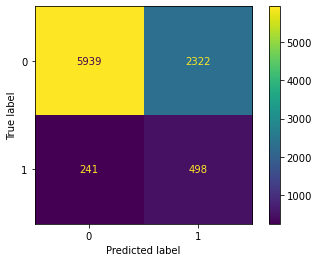

In [10]:
# Initialisation du modèle final
clf = loaded_model

# Matrice de confusion
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

# Print metrics: recall, precision and f1
print(classification_report(y_test, y_pred, output_dict=False))

## Metrique de classement 

- Les mesures de classement sont basées sur la façon dont le modèle classe les classes (le concept de séparabilité) 
- Zone sous la courbe de rappel de précision (PR AUC).
- Zone sous la courbe des caractéristiques de fonctionnement du récepteur (AUROC)

Les métriques de probabilité mesurent l’écart par rapport aux probabilités réelles de la classe : LogLoss et Brier Score. 
Notez que les probabilités prédites doivent être calibrées avant d’utiliser ces mesures.

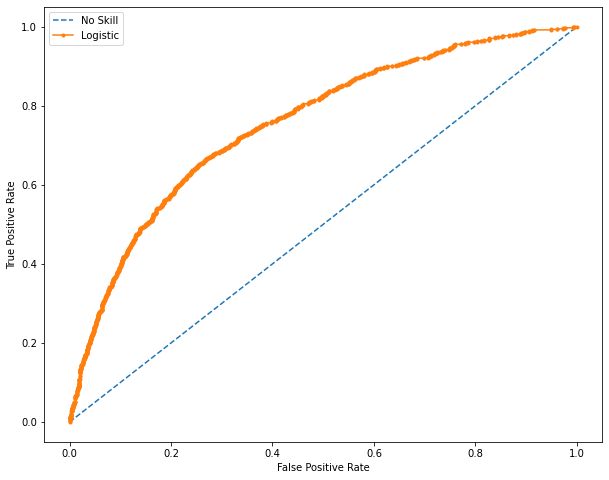

AUROC: 0.756


In [13]:
# Courbe de ROC
# La courbe ROC (Receiver Operator Characteristic)
# montre la relation entre le taux de vrai positif et le taux de faux positifs de notre classificateur.
plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# retrieve the probabilities for the positive class
yhat_positive = clf.predict_proba(X_test)[:, 1]

# calculate inputs for the roc curve
fpr, tpr, thresholds = roc_curve(y_test, yhat_positive)

# plot roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

# calculate and print AUROC
roc_auc = roc_auc_score(y_test, yhat_positive)
print('AUROC: %.3f' % roc_auc)

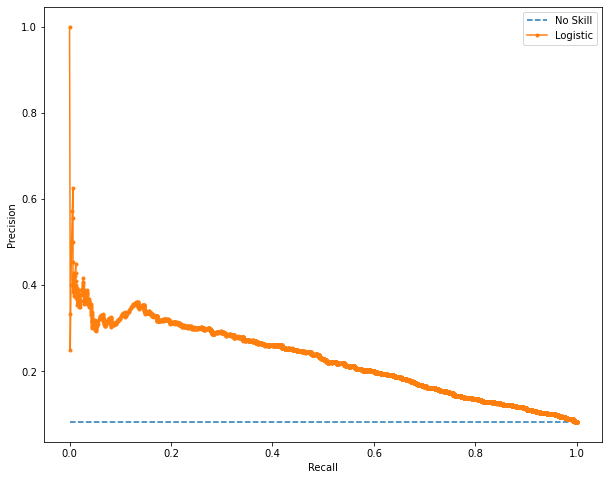

AUC PR: 0.228


In [14]:
# precision recall
# calculate the no skill line as the proportion of the positive class
plt.figure(figsize=(10, 8))
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate inputs for the PR curve
precision, recall, thresholds = precision_recall_curve(y_test, yhat_positive)

# plot PR curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.show()

# calculate and print PR AUC
auc_pr = auc(recall, precision)
print('AUC PR: %.3f' % auc_pr)


In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix

def custom_score(y_true, y_pred):
    # Relative loss and gains for each case
    TP_value = 0      
    FP_value = -1       
    FN_value = -10     
    TN_value = 0       

    # Confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred).ravel()

    # Full negative and positive cases
    N = TN + FP # total true not-default
    P = TP + FN # total true default

    gain = TP*TP_value + TN*TN_value + FP*FP_value + FN*FN_value
    best = N*TN_value + P*TP_value
    baseline = N*TN_value + P*FN_value
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain - baseline) / (best - baseline)
    return score


def predict_threshold(model, X, threshold=0.5):
    predictions = model.predict_proba(X)
    mask = (predictions[:, 1] > threshold)
    return mask.astype(int)


def custom_scorer(model, X, y_true):
    scores = []
    for threshold in np.linspace(0, 1, num=101):
    #threshold = 0.5
        y_pred = predict_threshold(model, X, threshold=threshold)
        score = custom_score(y_true, y_pred)
        scores.append(score)
    # print(max(scores))
    return max(scores)

Max score: 0.36562922868741543
Optimal threshold: 0.52


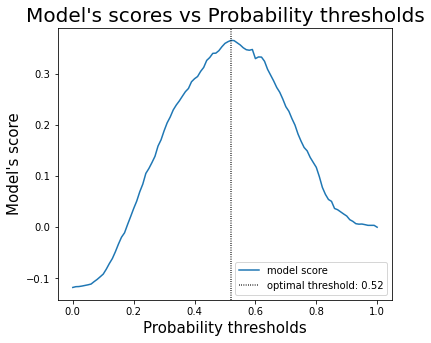

In [18]:
import numpy as np

scores = []
for threshold in np.linspace(0, 1, num=101):
    y_pred = predict_threshold(clf, X_test, threshold=threshold)
    score = custom_score(y_test, y_pred)
    scores.append(score)
fig, ax = plt.subplots(figsize=(6, 5))
plt.plot(np.linspace(0, 1, num=101), scores, label="model score")

max_score = max(scores)
opt_threshold = np.linspace(0, 1, num=101)[scores.index(max_score)]

plt.axvline(x=opt_threshold, color='k', dashes=(0.5, 1), label="optimal threshold: {}".format(opt_threshold))

plt.title("Model's scores vs Probability thresholds", fontsize=20)
plt.xlabel("Probability thresholds", fontsize=15)
plt.ylabel("Model's score", fontsize=15)
plt.legend()

print("Max score:", max_score)
print("Optimal threshold:", opt_threshold)

In [ ]:
# GINI 
#https://bridgeapi.io/blog-posts/quest-ce-que-le-score-de-gini-applique-au-credit-scoring/
# https://towardsdatascience.com/using-the-gini-coefficient-to-evaluate-the-performance-of-credit-score-models-59fe13ef420

In [15]:
# Creation d'un dataframe qui prend en colonne les donnees de Y_test et Y_Pred
A = y_test.tolist()
B = y_pred.tolist()
C = yhat_positive.tolist()
Donnees_Test = pd.DataFrame(list(zip(A,B,C)), columns=['y_test', 'y_pred','y_predict_proba'])
Donnees_Test

y_test  y_pred  y_predict_proba
0        0.0     0.0         0.160696
1        0.0     0.0         0.080502
2        0.0     1.0         0.645159
3        0.0     0.0         0.157432
4        0.0     0.0         0.433157
...      ...     ...              ...
8995     0.0     0.0         0.171501
8996     1.0     1.0         0.928088
8997     0.0     1.0         0.540040
8998     0.0     1.0         0.531354
8999     0.0     0.0         0.348494

[9000 rows x 3 columns]

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84      8261
         1.0       0.19      0.65      0.29       739

    accuracy                           0.74      9000
   macro avg       0.57      0.70      0.56      9000
weighted avg       0.90      0.74      0.79      9000



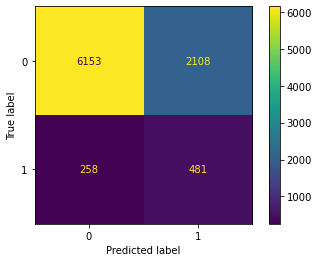

In [19]:
# Application du seuil et modification des labels
Donnees_Test['y_pred_thresh'] = np.where(Donnees_Test['y_predict_proba']> opt_threshold,1,0)

# Matrice de confusion
cm_thresh = confusion_matrix(Donnees_Test['y_test'], Donnees_Test['y_pred_thresh'])
cm_display_thresh = ConfusionMatrixDisplay(cm_thresh).plot()

# Print metrics: recall, precision and f1
print(classification_report(Donnees_Test['y_test'], Donnees_Test['y_pred_thresh'], output_dict=False))

## FEATURE IMPORTANCE

In [20]:
# Initialisation de l'explainer et des valeurs shap
import shap
X_train_data = shap.sample(X_train,100, random_state=0)
X_test_data = shap.sample(X_test,100, random_state=0)
explainer = shap.KernelExplainer(clf.predict_proba, X_train_data)
shap_values = explainer.shap_values(X_test_data)

  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
#Sauvegarde de mas valeurs shap
filename = 'Shap_values'
# some time later...
pickle.dump(shap_values, open(filename, 'wb'))

In [22]:
#Sauvegarde de l'explainer shap
filename = 'explainer'
# some time later...
pickle.dump(explainer, open(filename, 'wb'))

In [ ]:
#Sauvegarde de mas valeurs X_test_data
X_test_data.to_csv("X_test_data_b.csv", index=False, header=True)

In [151]:
#Sauvegarde de mas valeurs X_test_data
X_test_data.to_csv("X_test_data.csv", index=False, header=True)

In [13]:
#Sauvegarde de mas valeurs X_test_data
filename = 'X_test_data'
# some time later...
pickle.dump(X_test_data, open(filename, 'wb'))

In [13]:
#Sauvegarde de mes valeurs X_test - X_test_data-244965
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
explainer = ClassifierExplainer(clf, X_test[:10], y_test[:10])
ExplainerDashboard(explainer).run()

Note: shap values for shap='kernel' normally get calculated against X_background, but paramater X_background=None, so setting X_background=shap.sample(X, 50)...
Generating self.shap_explainer = shap.KernelExplainer(model, X, link='identity')
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


  0%|          | 0/10 [00:00<?, ?it/s]

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.1.181:8050
Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "explainerdashboard.dashboards" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:8050/ (Press CTRL+C to quit)
192.168.1.181 - - [21/Jul/2022 09:23:58] "GET / HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 09:23:58] "GET /assets/bootstrap.min.css?m=1658324867.9525375 HTTP/1.1" 304 -
192.168.1.181 - - [21/Jul/2022 09:23:58] "GET /_dash-dependencies HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 09:23:58] "GET /_dash-layout HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 09:23:58] "GET /assets/favicon.ico?m=1658324867.9543304 HTTP/1.1" 304 -
192.168.1.181 - - [21/Jul/2022 09:23:58] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 09:23:59] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 09:23:59] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 10:43:36] "GET / HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 10:43:36] "GET /_dash-dependencies HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/

192.168.1.181 - - [21/Jul/2022 10:56:29] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 10:56:29] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 10:56:29] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 10:56:29] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 10:56:29] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 10:56:29] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 10:56:29] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 10:56:29] "POST /_dash-update-component HTTP/1.1" 204 -
192.168.1.181 - - [21/Jul/2022 10:56:29] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 10:56:30] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 10:56:30] "POST /_dash-update-component HTTP/1.1" 200 -
192.168.1.181 - - [21/Jul/2022 10:56:31] "P

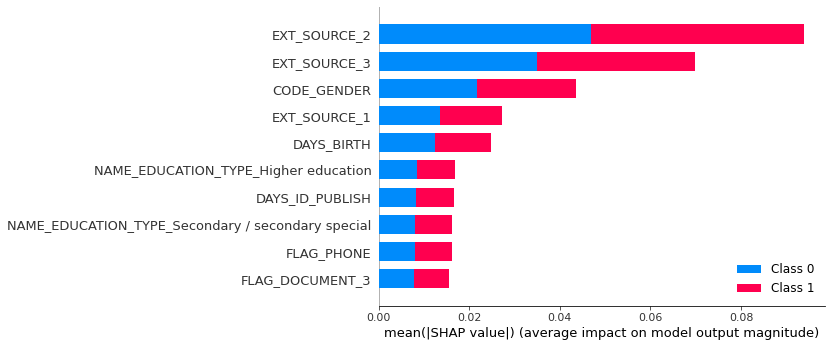

In [26]:
shap.initjs()
shap.summary_plot(shap_values, X_test_data, feature_names=X_test_data.columns, max_display=10)

In [24]:
# FEATURE IMPORTANCE LOCAL - explication des valeurs prédites pour un individu avec un refus de credit
#https://medium.com/@ulalaparis/repousser-les-limites-dexplicabilit%C3%A9-un-guide-avanc%C3%A9-de-shap-a33813a4bbfc
ind = 1
shap.force_plot(explainer.expected_value[1], shap_values[1][ind,:], X_test_data.iloc[ind,:])

In [25]:
# FEATURE IMPORTANCE LOCAL pour un individu avec une acceptation de credit
ind = 1
shap.force_plot(explainer.expected_value[0], shap_values[0][ind,:], X_test_data.iloc[ind,:])

In [ ]:
# Partie 2 : creation du dashboard
- concervoir une API pour la prediction (prioriser flask - regarder le cours - application web complete - creer une API avec Flash)
- penser à un dashboard (utiliser DASH en priorite)
- tester streamlite pour une application ou une interface (pas mal...) pour le dashboard 
- deploiement avec pythonanywhere ou heroku ou Azure 
Pour shap, il faudra penser à garder les valeurs de shap dans un csv pour les reafficher dans le dashboard

In [47]:
X_test_data_b = X_test_data.reset_index(drop=True)

In [48]:
X_test_data_b

SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0    383541.0          1.0           0.0              1.0           1.0   
1    311355.0          0.0           0.0              1.0           0.0   
2    354929.0          1.0           0.0              0.0           2.0   
3    288104.0          1.0           0.0              0.0           0.0   
4    279028.0          1.0           1.0              1.0           3.0   
5    184179.0          0.0           1.0              1.0           0.0   
6    105533.0          0.0           0.0              0.0           0.0   
7    411545.0          1.0           1.0              0.0           0.0   
8    437907.0          0.0           1.0              1.0           3.0   
9    430669.0          1.0           0.0              1.0           0.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           63000.0    450000.0      22018.5         450000.0   
1          270000.0   1762110.0      46480.5        1575000.0   
2          157500.0    260640.0      27499.5         225000.0   
3          180000.0    135000.0       9018.0         135000.0   
4          135000.0    454500.0      30271.5         454500.0   
5          202500.0    402993.0      42448.5         364500.0   
6          427500.0   1256400.0      36864.0         900000.0   
7          270000.0    835380.0      40320.0         675000.0   
8          225000.0   1264500.0      53703.0        1264500.0   
9           99000.0    113076.0       7776.0          81000.0   

   REGION_POPULATION_RELATIVE  ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0                    0.018634  ...                                 0.0   
1                    0.072508  ...                                 0.0   
2                    0.018801  ...                                 0.0   
3                    0.018209  ...                                 0.0   
4                    0.072508  ...                                 0.0   
5                    0.010006  ...                                 0.0   
6                    0.006233  ...                                 0.0   
7                    0.014520  ...                                 0.0   
8                    0.010500  ...                                 0.0   
9                    0.031329  ...                                 0.0   

   CC_NAME_CONTRACT_STATUS_Signed_MEAN  CC_NAME_CONTRACT_STATUS_Signed_SUM  \
0                                  0.0                                 0.0   
1                                  0.0                                 0.0   
2                                  0.0                                 0.0   
3                                  0.0                                 0.0   
4                                  0.0                                 0.0   
5                                  0.0                                 0.0   
6                                  0.0                                 0.0   
7                                  0.0                                 0.0   
8                                  0.0                                 0.0   
9                                  0.0                                 0.0   

   CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
0                                 0.0                              0.0   
1                                 0.0                              0.0   
2                                 0.0                              0.0   
3                                 0.0                              0.0   
4                                 0.0                              0.0   
5                                 0.0                              0.0   
6                                 0.0                              0.0   
7                                 0.0                              0.0   
8                                 0.0                              0.0   
9                                 0.0          

In [51]:
index_shap = X_test_data_b.index[X_test_data_b['SK_ID_CURR'] == 430669.0]

In [52]:
index_shap

Int64Index([9], dtype='int64')

In [54]:
shap.initjs()
Shap_graphiq = shap.force_plot(explainer.expected_value[1], shap_values[1][index_shap,:], X_test_data_b.iloc[index_shap,:])

In [ ]:
#Ajout des elements pour le dashboard

In [180]:
#ajout des elements de classification des dossiers


SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
244961    383541.0          1.0           0.0              1.0           1.0   
182350    311355.0          0.0           0.0              1.0           0.0   
220052    354929.0          1.0           0.0              0.0           2.0   
162248    288104.0          1.0           0.0              0.0           0.0   
154464    279028.0          1.0           1.0              1.0           3.0   
72593     184179.0          0.0           1.0              1.0           0.0   
4731      105533.0          0.0           0.0              0.0           0.0   
268833    411545.0          1.0           1.0              0.0           0.0   
291676    437907.0          0.0           1.0              1.0           3.0   
285510    430669.0          1.0           0.0              1.0           0.0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
244961           63000.0    450000.0      22018.5         450000.0   
182350          270000.0   1762110.0      46480.5        1575000.0   
220052          157500.0    260640.0      27499.5         225000.0   
162248          180000.0    135000.0       9018.0         135000.0   
154464          135000.0    454500.0      30271.5         454500.0   
72593           202500.0    402993.0      42448.5         364500.0   
4731            427500.0   1256400.0      36864.0         900000.0   
268833          270000.0    835380.0      40320.0         675000.0   
291676          225000.0   1264500.0      53703.0        1264500.0   
285510           99000.0    113076.0       7776.0          81000.0   

        REGION_POPULATION_RELATIVE  ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
244961                    0.018634  ...                                 0.0   
182350                    0.072508  ...                                 0.0   
220052                    0.018801  ...                                 0.0   
162248                    0.018209  ...                                 0.0   
154464                    0.072508  ...                                 0.0   
72593                     0.010006  ...                                 0.0   
4731                      0.006233  ...                                 0.0   
268833                    0.014520  ...                                 0.0   
291676                    0.010500  ...                                 0.0   
285510                    0.031329  ...                                 0.0   

        CC_NAME_CONTRACT_STATUS_Signed_MEAN  \
244961                                  0.0   
182350                                  0.0   
220052                                  0.0   
162248                                  0.0   
154464                                  0.0   
72593                                   0.0   
4731                                    0.0   
268833                                  0.0   
291676                                  0.0   
285510                                  0.0   

        CC_NAME_CONTRACT_STATUS_Signed_SUM  \
244961                                 0.0   
182350                                 0.0   
220052                                 0.0   
162248                                 0.0   
154464                                 0.0   
72593                                  0.0   
4731                                   0.0   
268833                                 0.0   
291676                                 0.0   
285510                                 0.0   

        CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
244961                                 0.0                              0.0   
182350                                 0.0                              0.0   
220052                                 0.0                              0.0   
162248                                 0.0                              0.0   
154464                                 0.0                        

In [55]:
Shap_graphiq

In [19]:
previous_application.loc[previous_application['SK_ID_CURR']== 383541, ['SK_ID_CURR','NAME_CONTRACT_TYPE','AMT_CREDIT']]

SK_ID_CURR NAME_CONTRACT_TYPE  AMT_CREDIT
47156        383541         Cash loans         0.0
93736        383541    Revolving loans    180000.0
251681       383541    Revolving loans         0.0
360849       383541     Consumer loans     68706.0
438447       383541    Revolving loans     90000.0
441534       383541         Cash loans         0.0
471515       383541         Cash loans    342157.5
783338       383541         Cash loans    284400.0
1140285      383541     Consumer loans     62932.5
1317448      383541     Consumer loans     86976.0
1428398      383541         Cash loans         0.0

In [21]:
r = application_train.loc[application_train['SK_ID_CURR']== 383541, ['DAYS_BIRTH']]

In [27]:
application_train['DAYS_BIRTH'].dtypes

dtype('int64')

In [30]:
r = round(application_train['DAYS_BIRTH'] / -365)

In [31]:
r

0         26.0
1         46.0
2         52.0
3         52.0
4         55.0
          ... 
307506    26.0
307507    57.0
307508    41.0
307509    33.0
307510    46.0
Name: DAYS_BIRTH, Length: 307511, dtype: float64

In [217]:
X_test_data['seuil_prediction'] = clf.predict_proba(X_test_data)[:, 1]

In [116]:
a = list(X_test_data.loc[X_test_data['SK_ID_CURR']== 383541,'seuil_prediction']) 
a[0]

0.876572512408065

In [88]:
dr = X_test_data.loc[X_test_data['SK_ID_CURR']==383541,'seuil_prediction'].values

In [91]:

dre = dr.astype(float) 

In [92]:
dre

array([0.87657251])

In [83]:
A = X_test_data[['seuil_prediction','SK_ID_CURR']].values

In [85]:
A[2]

array([2.19580649e-01, 3.54929000e+05])

In [93]:
def app(ID):
    if 0 <= X_test_data.loc[X_test_data['SK_ID_CURR']==ID,'seuil_prediction'].values <.26:
        appreciation = "Tres mauvais dossier"
    if 0.26 <= X_test_data.loc[X_test_data['SK_ID_CURR']==ID,'seuil_prediction'].values <.53:
        appreciation = "Mauvais dossier"
    if 0.53 <= X_test_data.loc[X_test_data['SK_ID_CURR']==ID,'seuil_prediction'].values < .76:
        appreciation = "Dossier acceptable"
    if 0.76 <= X_test_data.loc[X_test_data['SK_ID_CURR']==ID,'seuil_prediction'].values < .89:
        appreciation = "Bon dossier"
    else:
        appreciation = "Tres bon dossier"
    return appreciation

In [120]:
X_test_data['seuil_prediction'].describe()

count    100.000000
mean       0.412226
std        0.223409
min        0.032024
25%        0.244215
50%        0.372980
75%        0.591067
max        0.893537
Name: seuil_prediction, dtype: float64

In [98]:
X_test_data['appreciation_dossier'] = X_test_data['SK_ID_CURR'].apply(lambda x : app(x))


In [168]:
X_test_data['appreciation_dossier']

KeyError: 'appreciation_dossier'

In [128]:
app(430669)

'Bon dossier'

In [121]:
X_test_data.loc[X_test_data['SK_ID_CURR']== 311355,'appreciation_dossier']

182350    Mauvais dossier
Name: appreciation_dossier, dtype: object

In [108]:
df_indiv_similaire = X_test_data.loc[X_test_data['appreciation_dossier'] == "Bon dossier"]
ID_similaire = list(df_indiv_similaire['SK_ID_CURR'])
filtre_dossier_similaire = application_train[application_train['SK_ID_CURR'].isin(ID_similaire)]

In [112]:
filtre_dossier_similaire

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
3832        104481       0         Cash loans           M            Y   
13532       115768       0         Cash loans           F            N   
14631       117072       0         Cash loans           M            N   
15827       118468       0         Cash loans           F            N   
41400       147929       0         Cash loans           M            N   
63332       173447       0         Cash loans           M            Y   
78250       190720       1         Cash loans           F            Y   
109073      226502       0         Cash loans           F            N   
124787      244717       0         Cash loans           F            N   
132676      253885       0         Cash loans           F            N   
138092      260144       0         Cash loans           M            Y   
161989      287793       0         Cash loans           F            Y   
185771      315360       0         Cash loans           M            Y   
207852      340917       0         Cash loans           F            Y   
219993      354858       0         Cash loans           M            Y   
221833      356976       0         Cash loans           F            N   
224537      360059       0         Cash loans           F            N   
238233      375890       0         Cash loans           M            N   
244965      383541       1         Cash loans           F            N   
261712      402950       0         Cash loans           F            N   
262709      404165       0         Cash loans           F            Y   
266243      408426       0         Cash loans           M            N   
268837      411545       1         Cash loans           F            Y   
270931      414081       0         Cash loans           M            N   
285514      430669       1         Cash loans           F            N   
287664      433220       1         Cash loans           M            Y   
288758      434525       0         Cash loans           F            Y   
296598      443635       0    Revolving loans           F            N   
299115      446519       0         Cash loans           F            Y   
301057      448782       0         Cash loans           M            N   
304306      452567       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
3832                 Y             0          202500.0    165915.0   
13532                N             0          121500.0    990000.0   
14631                Y             1          157500.0    814041.0   
15827                N             1          112500.0    239850.0   
41400                Y             0          135000.0    545040.0   
63332                Y             0          202500.0    373311.0   
78250                Y             1          135000.0    675000.0   
109073               N             0          148500.0   1113133.5   
124787               Y             1          144000.0    634482.0   
132676               Y             1          360000.0    508500.0   
138092               Y             0          171000.0    835380.0   
161989               Y             1          135000.0    807984.0   
185771               N             2          112500.0    544491.0   
207852               Y             0           90000.0    288873.0   
219993               N             0          234000.0   1762110.0   
221833               N             2          135000.0    314055.0   
224537               N             0           99000.0    781695.0   
238233               Y             0           99000.0    194922.0   
244965               N             1           63000.0    450000.0   
261712               N             1           90000.0    450000.0   
262709               Y             1           90000.0    640080.0   
266243               N             0          225000.0    225000.0   
268837               Y       

In [95]:

previous_application.groupby('NAME_CONTRACT_STATUS')['AMT_ANNUITY', 'AMT_CREDIT']\
.agg(['count','mean'])

AMT_ANNUITY               AMT_CREDIT               
                           count          mean      count           mean
NAME_CONTRACT_STATUS                                                    
Approved                 1036773  14720.350105    1036780  202564.182131
Canceled                   10514  30289.763892     316319   24187.057127
Refused                   249780  20498.160274     290678  371689.841222
Unused offer                 912  10145.798635      26436   69783.990800

In [113]:
filtre_dossier_similaire['CODE_GENDER'].value_counts()

F    19
M    12
Name: CODE_GENDER, dtype: int64

In [127]:
ze = list(X_test_data.loc[X_test_data['SK_ID_CURR']==311355,'seuil_prediction'])[0]
ze

0.24711408146045602

In [195]:
def appreciation_dossier(ID):
    X_test_data = pd.read_csv("C:/Users/akabe/PycharmProjects/pythonProject/donnees/X_test_data_b.csv", sep=',')
    # probabilite et prediction
    #X_test_data = X_test_data.loc[X_test_data['SK_ID_CURR'] == ID]
    X_test_data['proba_client'] = clf.predict_proba(X_test_data)[:, 1]
    #condition d'appreciation du dossier
    if 0 <= list(X_test_data.loc[X_test_data['SK_ID_CURR']==ID,'proba_client'])[0] < .26:
         appreciation = "Tres mauvais dossier"
    if 0.26 <= list(X_test_data.loc[X_test_data['SK_ID_CURR']==ID,'proba_client'])[0] < .53:
         appreciation = "Mauvais dossier"
    if 0.53 <= list(X_test_data.loc[X_test_data['SK_ID_CURR']==ID,'proba_client'])[0] < .76:
         appreciation = "Dossier acceptable"
    if 0.76 <= list(X_test_data.loc[X_test_data['SK_ID_CURR']==ID,'proba_client'])[0] < .89:
         appreciation = "Bon dossier"
    if 0.89 <= list(X_test_data.loc[X_test_data['SK_ID_CURR']==ID,'proba_client'])[0] <= 1:
         appreciation = "Tres bon dossier"
    return appreciation

In [197]:
X_test_data['appreciation'] = X_test_data['SK_ID_CURR'].apply(lambda x : appreciation_dossier(x))

In [199]:
Qualite_dossier = X_test_data[['SK_ID_CURR','appreciation']] 

In [200]:
Qualite_dossier

SK_ID_CURR          appreciation
244961    383541.0           Bon dossier
182350    311355.0  Tres mauvais dossier
220052    354929.0  Tres mauvais dossier
162248    288104.0  Tres mauvais dossier
154464    279028.0  Tres mauvais dossier
72593     184179.0  Tres mauvais dossier
4731      105533.0  Tres mauvais dossier
268833    411545.0           Bon dossier
291676    437907.0       Mauvais dossier
285510    430669.0    Dossier acceptable

In [201]:
#Sauvegarde de mas valeurs X_test_data
Qualite_dossier.to_csv("Qualite_dossier.csv", index=False, header=True)

In [139]:
ID = 430669
if 0 <= list(X_test_data.loc[X_test_data['SK_ID_CURR'] == ID, 'proba_client'])[0] < .26:
        X_test_data['appr'] = "Tres mauvais dossier"
if 0.26 <= list(X_test_data.loc[X_test_data['SK_ID_CURR'] == ID, 'proba_client'])[0] < .53:
         X_test_data['appr'] = "Mauvais dossier"
if 0.53 <= list(X_test_data.loc[X_test_data['SK_ID_CURR'] == ID, 'proba_client'])[0] < .76:
         X_test_data['appr'] = "Dossier acceptable"
if 0.76 <= list(X_test_data.loc[X_test_data['SK_ID_CURR'] == ID, 'proba_client'])[0] < .89:
         X_test_data['appr'] = "Bon dossier"
if 0.89 <= list(X_test_data.loc[X_test_data['SK_ID_CURR']==ID,'proba_client'])[0] <= 1:
         X_test_data['appr'] = "Tres bon dossier"

KeyError: 'proba_client'

In [145]:
X_test_data.drop(columns=['CC_COUNT','seuil_prediction'],inplace=True)

In [150]:
X_test_data['appreciation_dossier']

244961        Bon dossier
182350    Mauvais dossier
220052    Mauvais dossier
162248    Mauvais dossier
154464    Mauvais dossier
               ...       
168114    Mauvais dossier
296594        Bon dossier
279504    Mauvais dossier
238229        Bon dossier
261178    Mauvais dossier
Name: appreciation_dossier, Length: 100, dtype: object

In [152]:
#Sauvegarde de mas valeurs X_test_data
X_test_data.to_csv("VAB.csv", index=False, header=True)

In [155]:
list_data = ["X_test_data_b"]

for i in list_data:
    print(i+".csv")
    globals()[i] = pd.read_csv(i+".csv",sep= ',')

X_test_data_b.csv


In [156]:
X_test_data_b.head()

SK_ID_CURR  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0    383541.0          1.0           0.0              1.0           1.0   
1    311355.0          0.0           0.0              1.0           0.0   
2    354929.0          1.0           0.0              0.0           2.0   
3    288104.0          1.0           0.0              0.0           0.0   
4    279028.0          1.0           1.0              1.0           3.0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0           63000.0    450000.0      22018.5         450000.0   
1          270000.0   1762110.0      46480.5        1575000.0   
2          157500.0    260640.0      27499.5         225000.0   
3          180000.0    135000.0       9018.0         135000.0   
4          135000.0    454500.0      30271.5         454500.0   

   REGION_POPULATION_RELATIVE  ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0                    0.018634  ...                                 0.0   
1                    0.072508  ...                                 0.0   
2                    0.018801  ...                                 0.0   
3                    0.018209  ...                                 0.0   
4                    0.072508  ...                                 0.0   

   CC_NAME_CONTRACT_STATUS_Signed_MEAN  CC_NAME_CONTRACT_STATUS_Signed_SUM  \
0                                  0.0                                 0.0   
1                                  0.0                                 0.0   
2                                  0.0                                 0.0   
3                                  0.0                                 0.0   
4                                  0.0                                 0.0   

   CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
0                                 0.0                              0.0   
1                                 0.0                              0.0   
2                                 0.0                              0.0   
3                                 0.0                              0.0   
4                                 0.0                              0.0   

   CC_NAME_CONTRACT_STATUS_nan_MAX  CC_NAME_CONTRACT_STATUS_nan_MEAN  \
0                              0.0                               0.0   
1                              0.0                               0.0   
2                              0.0                               0.0   
3                              0.0                               0.0   
4                              0.0                               0.0   

   CC_NAME_CONTRACT_STATUS_nan_SUM  CC_NAME_CONTRACT_STATUS_nan_VAR  \
0                              0.0                              0.0   
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   appreciation_dossier  
0           Bon dossier  
1       Mauvais dossier  
2       Mauvais dossier  
3       Mauvais dossier  
4       Mauvais dossier  

[5 rows x 796 columns]

In [157]:
z = X_test_data.loc[X_test_data['SK_ID_CURR'] == 383541,"appreciation_dossier"]

In [161]:
z

244961    Bon dossier
Name: appreciation_dossier, dtype: object

In [162]:
VAB['proba_client']

KeyError: 'proba_client'

In [185]:
X_test_data[['SK_ID_CURR','seuil_prediction']]

KeyError: "['seuil_prediction'] not in index"

In [192]:
proba = list(X_test_data. "proba_client"])
if 0 <= proba[0] < .26:
    X_test_data['Appreciation'] = "Tres mauvais dossier"
if 0.26 <= proba[0] < .53:
    X_test_data['Appreciation'] = "Mauvais dossier"
if 0.53 <= proba[0] < .76:
    X_test_data['Appreciation'] = "Dossier acceptable"
if 0.76 <= proba[0] < .89:
    X_test_data['Appreciation'] = "Bon dossier"
else:
    X_test_data['Appreciation'] = "Tres bon dossier"

NameError: name 'donnees_client' is not defined

In [226]:
X_test_data['proba_client_bis'] = np.where(X_test_data['seuil_prediction']> 0.52,X_test_data['seuil_prediction'],X_test_data['seuil_prediction']*(-1))


In [219]:
X_test_data['seuil_prediction']

244961    0.876573
182350    0.247114
220052    0.219581
162248    0.188386
154464    0.087045
72593     0.245034
4731      0.255723
268833    0.782619
291676    0.393647
285510    0.737343
Name: seuil_prediction, dtype: float64

In [227]:
X_test_data[['seuil_prediction','proba_client_bis']]

seuil_prediction  proba_client_bis
244961          0.876573          0.876573
182350          0.247114         -0.247114
220052          0.219581         -0.219581
162248          0.188386         -0.188386
154464          0.087045         -0.087045
72593           0.245034         -0.245034
4731            0.255723         -0.255723
268833          0.782619          0.782619
291676          0.393647         -0.393647
285510          0.737343          0.737343

In [229]:
var data = [
  {
    domain: {x: [0, 1], y: [0, 1]},
    value: 450,
    title: {text: "Speed"},
    type: "indicator",
    mode: "gauge+number+delta",
    delta: {reference: 380},
    gauge: {
      axis: {range: [null, 500]},
      steps: [
        {range: [0, 250], color: "lightgray"},
        {range: [250, 400], color: "gray"}
      ],
      threshold: {
        line: {color: "red", width: 4},
        thickness: 0.75,
        value: 490
      }
    }
  }
];

var layout = {width: 600, height: 450, margin: {t: 0, b: 0}};
Plotly.newPlot('myDiv', data, layou

SyntaxError: invalid syntax (<ipython-input-229-492d4a4417cc>, line 1)